# Projet Accidents corporels de la circulation routière

## Auteur : Nicolas Lejay

## Juin 2023

***
### A propos
- Ce projet est réalisé à partir de fichiers regroupant les informations sur les accidents corporels de la circulation routière entre 2005 et 2021. L'Observatoire National Interministérielle de la Sécurité Routière fournit quatre fichiers par année : sur les caractéristiques de l'accident, sur le lieu, sur les véhicules impliqués et enfin sur les personnes impliquées. Ici, nous utiliserons quatres fichiers qui sont la compilations de l'ensemble des années. Ces fichiers ont également été nettoyés.
- Pour toute information sur le jeu de données, la signification des variablmes ainsi que sur la définition donnée à « accident corporel de la circulation routière », se repporter au fichier README.md et à la notice de l'ONISR fournis dans le repository : https://github.com/nlejay/accidents_circulation

***
# 1. Importation des fichiers

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmasher as cmr   #colormaps adaptées aux daltoniens
import pingouin
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
import statsmodels.stats.multicomp as multi
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.lines as mlines
import folium
from folium.plugins import FloatImage
from tqdm import tqdm

# Changement de police des graphiques
plt.rc('font', family = 'serif', serif = 'cmr10')
plt.rcParams.update({"text.usetex": True, "axes.formatter.use_mathtext" : True})

In [2]:
df_caract = pd.read_csv('src/caracteristiques_net_19_06_23.csv',
                        index_col=0,
                        # colonnes avec plusieurs types de formats converties au format str
                        dtype={'hrmn': 'str', 'com' : 'str', 'lat':'str', 'long':'str', 'dep':'str', 'gps':'str'})

df_lieux = pd.read_csv('src/lieux_net_19_06_23.csv',
                        index_col=0,
                        # colonnes avec plusieurs types de formats converties au format str
                        dtype={'voie': 'str', 'pr' : 'str', 'pr1':'str', 'larrout':'str', 'lartpc':'str'})

df_usagers = pd.read_csv('src/usagers_net_19_06_23.csv',
                         index_col=0,
                         # colonnes avec plusieurs types de formats converties au format str
                         dtype={'actp':'str', 'id_vehicule':'str'})
                         
df_veh = pd.read_csv('src/vehicules_net_19_06_23.csv',
                     index_col=0,
                     # colonnes avec plusieurs types de formats converties au format str
                     dtype={'id_vehicule':'str'})

**Dataframe *df_caract***

In [3]:
df_caract.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,1.0,2.0,AUTOROUTE A3,48.8962100,2.4701200
1,201900000002,30,11,2019,02:50,3.0,93,93066,1,1.0,1.0,6.0,AUTOROUTE A1,48.9307000,2.3688000
2,201900000003,28,11,2019,15:15,1.0,92,92036,1,1.0,1.0,4.0,AUTOROUTE A86,48.9358718,2.3191744
3,201900000004,30,11,2019,20:20,5.0,94,94069,1,1.0,1.0,4.0,A4,48.8173295,2.4281502
4,201900000005,30,11,2019,04:00,3.0,94,94028,1,1.0,1.0,2.0,A86 INT,48.7763620,2.4332540


In [4]:
df_caract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121571 entries, 0 to 1121570
Data columns (total 15 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Num_Acc  1121571 non-null  int64  
 1   jour     1121571 non-null  int64  
 2   mois     1121571 non-null  int64  
 3   an       1121571 non-null  int64  
 4   hrmn     1121571 non-null  object 
 5   lum      1121566 non-null  float64
 6   dep      1121571 non-null  object 
 7   com      1121569 non-null  object 
 8   agg      1121571 non-null  int64  
 9   int      1121463 non-null  float64
 10  atm      1121477 non-null  float64
 11  col      1120015 non-null  float64
 12  adr      978295 non-null   object 
 13  lat      634503 non-null   object 
 14  long     634499 non-null   object 
dtypes: float64(4), int64(5), object(6)
memory usage: 136.9+ MB


**Dataframe *df_lieux***

In [5]:
df_lieux.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,1.0,3,0.0,NaN,3.0,10.0,0.0,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
1,201900000002,1.0,1,0.0,NaN,1.0,2.0,0.0,4.0,3,845,2.0,NaN,NaN,1.0,0.0,1.0,70.0
2,201900000003,1.0,86,0.0,NaN,3.0,8.0,0.0,1.0,10,500,3.0,NaN,NaN,1.0,0.0,1.0,90.0
3,201900000004,1.0,4,0.0,NaN,3.0,5.0,0.0,1.0,2,299,1.0,NaN,NaN,1.0,0.0,1.0,90.0
4,201900000005,1.0,86,0.0,INT,1.0,3.0,0.0,1.0,41,0,3.0,NaN,NaN,1.0,2.0,1.0,90.0


In [6]:
df_lieux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121571 entries, 0 to 1121570
Data columns (total 18 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Num_Acc  1121571 non-null  int64  
 1   catr     1121570 non-null  float64
 2   voie     1014391 non-null  object 
 3   v1       485747 non-null   float64
 4   v2       51369 non-null    object 
 5   circ     1110973 non-null  float64
 6   nbv      1118840 non-null  float64
 7   vosp     1117652 non-null  float64
 8   prof     1119591 non-null  float64
 9   pr       646087 non-null   object 
 10  pr1      644268 non-null   object 
 11  plan     1119259 non-null  float64
 12  lartpc   902739 non-null   object 
 13  larrout  902739 non-null   object 
 14  surf     1090453 non-null  float64
 15  infra    1116163 non-null  float64
 16  situ     1116466 non-null  float64
 17  vma      163102 non-null   float64
dtypes: float64(11), int64(1), object(6)
memory usage: 162.6+ MB


**dataframe *df_usagers***

In [7]:
df_usagers.head()

,Num_Acc,place,catu,grav,sexe,trajet,locp,actp,etatp,an_nais,num_veh,id_vehicule,secu1,secu2,secu3
0,200500000001,1.0,1.0,4.0,1.0,1.0,0.0,0,NaN,1976.0,A01,NaN,1.0,NaN,NaN
1,200500000001,1.0,1.0,3.0,2.0,3.0,0.0,0,NaN,1968.0,B02,NaN,1.0,NaN,NaN
2,200500000001,2.0,2.0,1.0,1.0,0.0,0.0,0,NaN,1964.0,B02,NaN,1.0,NaN,NaN
3,200500000001,4.0,2.0,1.0,1.0,0.0,0.0,0,NaN,2004.0,B02,NaN,3.0,NaN,NaN
4,200500000001,5.0,2.0,1.0,1.0,0.0,0.0,0,NaN,1998.0,B02,NaN,1.0,NaN,NaN


In [8]:
df_usagers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506762 entries, 0 to 2509619
Data columns (total 15 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Num_Acc      int64  
 1   place        float64
 2   catu         float64
 3   grav         float64
 4   sexe         float64
 5   trajet       float64
 6   locp         float64
 7   actp         object 
 8   etatp        float64
 9   an_nais      float64
 10  num_veh      object 
 11  id_vehicule  object 
 12  secu1        float64
 13  secu2        float64
 14  secu3        float64
dtypes: float64(11), int64(1), object(3)
memory usage: 306.0+ MB


On remarque plus d'observations que dans les deux dataframes précédents. C'est normal : un accident peut impliquer une ou plusieurs personnes.

**Dataframe *df_veh***

In [9]:
df_veh.head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,201900000001,138 306 524,B01,2.0,7.0,0.0,2.0,5.0,23.0,1.0,NaN
1,201900000001,138 306 525,A01,2.0,17.0,1.0,0.0,3.0,11.0,1.0,NaN
2,201900000002,138 306 523,A01,1.0,7.0,4.0,0.0,1.0,0.0,1.0,NaN
3,201900000003,138 306 520,A01,1.0,7.0,0.0,2.0,1.0,2.0,1.0,NaN
4,201900000003,138 306 521,B01,1.0,7.0,1.0,0.0,4.0,2.0,1.0,NaN


In [10]:
df_veh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914902 entries, 0 to 1914901
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Num_Acc      int64  
 1   id_vehicule  object 
 2   num_veh      object 
 3   senc         float64
 4   catv         float64
 5   obs          float64
 6   obsm         float64
 7   choc         float64
 8   manv         float64
 9   motor        float64
 10  occutc       float64
dtypes: float64(8), int64(1), object(2)
memory usage: 175.3+ MB


Là-aussi, un accident implique souvent plusieurs véhicules. Nous avons donc plus de lignes dans ce dataframe que dans celui sur les accidents.

***
# 2.Étude temporelle
## 2.1. Évolution du nombre d'accidents, de morts et de blessés chaque année
### 2.1.1. Évolution du nombre et variation en pourcentage

1 121 571 accidents répertoriés sur 17 ans, soit une moyenne de 65975 par an. Mais comment a évolué le nombre d'accidents corporels sur la période 2005-2017 ? Et comment ont évolué le nombre de morts et de blessés ?

In [11]:
# Calcul du nombre d'accidents par an
acc_par_an = (df_caract
              .groupby('an')
              .agg(Effectif = pd.NamedAgg('Num_Acc','count'))
              .reset_index())

#Calcul de la variation annuelle
acc_par_an['var_pourc'] = acc_par_an['Effectif'].pct_change() * 100

acc_par_an.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
an,2005.0,2006.000000,2007.000000,2008.000000,2009.000000,2010.000000,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.00000,2019.000000,2020.00000,2021.000000
Effectif,87026.0,82993.000000,83850.000000,76767.000000,74409.000000,69379.000000,66974.000000,62250.000000,58397.000000,59854.000000,58654.000000,59432.000000,60701.000000,57783.00000,58840.000000,47744.00000,56518.000000
var_pourc,NaN,-4.634247,1.032617,-8.447227,-3.071632,-6.759935,-3.466467,-7.053483,-6.189558,2.494991,-2.004879,1.326423,2.135213,-4.80717,1.829258,-18.85792,18.377178


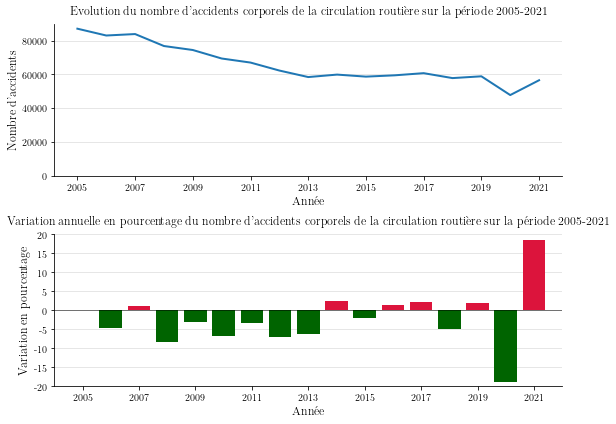

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(acc_par_an['an'], acc_par_an['Effectif'], color="tab:blue", linewidth=2)
ax1.set_ylim(0,90000)
ax1.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax1.set_xlabel('Année', size=12)
ax1.set_ylabel("Nombre d'accidents", size=12)
ax1.set_title("Evolution du nombre d'accidents corporels de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax1.grid(visible=True, axis='y', color="#e0e0e0")


couleurs = ["crimson" if acc_par_an.iloc[i,2]>0 else "darkgreen" for i in range(len(acc_par_an))]
ax2.bar(acc_par_an['an'], acc_par_an['var_pourc'], color=couleurs)
ax2.set_xlabel('Année', size=12)
ax2.set_xlim(2004,2022)
ax2.set_ylabel("Variation en pourcentage", size=12)
ax2.set_ylim(-20,20)
ax2.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax2.set_yticks([i for i in range(-20,25,5)], [i for i in range(-20,25,5)])
ax2.grid(visible=True, axis='y', color="#e0e0e0")
ax2.set_title("Variation annuelle en pourcentage du nombre d'accidents corporels de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax2.set_axisbelow(True)
ax2.hlines(0,2004,2022, color='black', linewidth=0.5)

sns.despine()
plt.tight_layout()
im = plt.gcf()
im.savefig('img/evol_acc.png', dpi=200, bbox_inches="tight")
plt.show()

On observe une baisse de 2005 à 2013 puis une stabilisation autour de 60 000 accidents par an. Pour l'année 2020, la chute est sûrement due aux confinents pendant l'épidémie de COVID-19. On remarque d'ailleurs une hausse en 2021 qui ramène quasiment au niveau pré-2020.

Concentrons-nous maintenant sur le nombre de morts et de blessés. Pour cela, une jointure entre *df_caract* et *df_usagers* est nécessaire cr l'année n'est renseignée que dans *df_caract*.

In [13]:
# Calcul du nombre de morts et blessés de chaque type chaque année
gravite_par_an = (df_usagers[['Num_Acc','grav']]
                  .merge(df_caract[['Num_Acc', 'an']], how='inner', left_on='Num_Acc', right_on='Num_Acc')
                  .pivot_table(index='an', columns='grav', values='Num_Acc', aggfunc='count')
                  .rename(columns={1:'Indemne',
                                    2:'Tué',
                                    3:'Hospitalisé',
                                    4:'Bléssé léger'})
                 )

gravite_par_an.transpose().head()

an,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
grav,,,,,,,,,,,,,,,,,
Indemne,80124,76027,76757,69468,67664,62737,60519,56491,52599,53416,53353,54514,56178,54126,55271,43229,55108
Tué,5543,4940,4836,4440,4440,4172,4109,3842,3426,3554,3608,3652,3599,3392,3497,2780,3219
Hospitalisé,40760,41803,39720,36121,34484,31306,30616,28088,26875,27491,27696,28352,28977,22162,20852,16772,19085
Bléssé léger,70760,64045,66873,60651,59139,55782,53183,50057,45688,47597,45628,46697,47124,50300,53256,42451,51681


In [14]:
# Calcul de la variation annuelle en pourcentage
var_gravite_par_an = round(gravite_par_an.pct_change()*100, 1)
var_gravite_par_an.transpose()

an,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
grav,,,,,,,,,,,,,,,,,
Indemne,NaN,-5.1,1.0,-9.5,-2.6,-7.3,-3.5,-6.7,-6.9,1.6,-0.1,2.2,3.1,-3.7,2.1,-21.8,27.5
Tué,NaN,-10.9,-2.1,-8.2,0.0,-6.0,-1.5,-6.5,-10.8,3.7,1.5,1.2,-1.5,-5.8,3.1,-20.5,15.8
Hospitalisé,NaN,2.6,-5.0,-9.1,-4.5,-9.2,-2.2,-8.3,-4.3,2.3,0.7,2.4,2.2,-23.5,-5.9,-19.6,13.8
Bléssé léger,NaN,-9.5,4.4,-9.3,-2.5,-5.7,-4.7,-5.9,-8.7,4.2,-4.1,2.3,0.9,6.7,5.9,-20.3,21.7


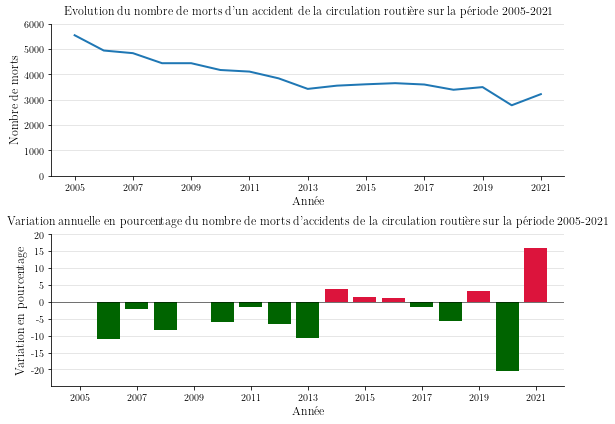

In [15]:
grav_par_an_long = gravite_par_an.unstack().reset_index().rename(columns={0:'Effectif'})
morts_par_an = grav_par_an_long.loc[grav_par_an_long['grav']=='Tué']
pd.options.mode.chained_assignment = None
morts_par_an['var_pourc'] = morts_par_an['Effectif'].pct_change()*100

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(morts_par_an['an'], morts_par_an['Effectif'], color="tab:blue", linewidth=2)
ax1.set_ylim(0,6000)
ax1.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax1.set_xlabel('Année', size=12)
ax1.set_ylabel("Nombre de morts", size=12)
ax1.set_title("Evolution du nombre de morts d'un accident de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax1.grid(visible=True, axis='y', color="#e0e0e0")


couleurs = ["crimson" if morts_par_an.iloc[i,3]>0 else "darkgreen" for i in range(len(morts_par_an))]
ax2.bar(morts_par_an['an'], morts_par_an['var_pourc'], color=couleurs)
ax2.set_xlabel('Année', size=12)
ax2.set_xlim(2004,2022)
ax2.set_ylabel("Variation en pourcentage", size=12)
ax2.set_ylim(-25,20)
ax2.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax2.set_yticks([i for i in range(-20,25,5)], [i for i in range(-20,25,5)])
ax2.grid(visible=True, axis='y', color="#e0e0e0")
ax2.set_title("Variation annuelle en pourcentage du nombre de morts d'accidents de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax2.set_axisbelow(True)
ax2.hlines(0,2004,2022, color='black', linewidth=0.5)

sns.despine()
plt.tight_layout()
im = plt.gcf()
im.savefig('img/evol_morts.png', dpi=200, bbox_inches="tight")
plt.show()

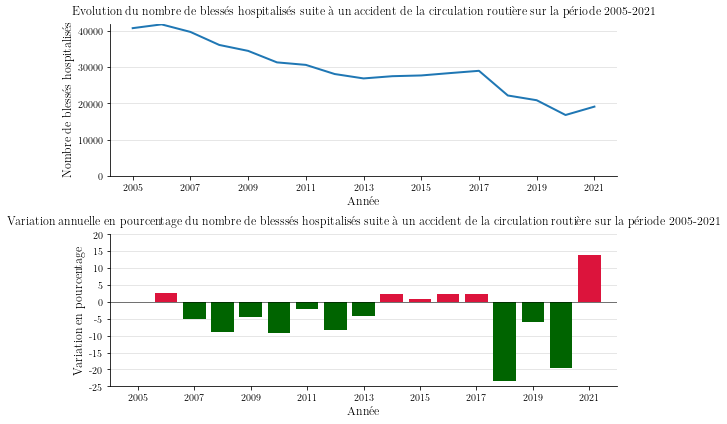

In [16]:
hosp_par_an = grav_par_an_long.loc[grav_par_an_long['grav']=='Hospitalisé']
hosp_par_an['var_pourc'] = hosp_par_an['Effectif'].pct_change()*100

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(hosp_par_an['an'], hosp_par_an['Effectif'], color="tab:blue", linewidth=2)
ax1.set_ylim(0,42000)
ax1.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax1.set_xlabel('Année', size=12)
ax1.set_ylabel("Nombre de blessés hospitalisés", size=12)
ax1.set_title("Evolution du nombre de blessés hospitalisés suite à un accident de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax1.grid(visible=True, axis='y', color="#e0e0e0")


couleurs = ["crimson" if hosp_par_an.iloc[i,3]>0 else "darkgreen" for i in range(len(hosp_par_an))]
ax2.bar(hosp_par_an['an'], hosp_par_an['var_pourc'], color=couleurs)
ax2.set_xlabel('Année', size=12)
ax2.set_xlim(2004,2022)
ax2.set_ylabel("Variation en pourcentage", size=12)
ax2.set_ylim(-20,20)
ax2.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax2.set_yticks([i for i in range(-25,25,5)], [i for i in range(-25,25,5)])
ax2.grid(visible=True, axis='y', color="#e0e0e0")
ax2.set_title("Variation annuelle en pourcentage du nombre de blesssés hospitalisés suite à un accident de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax2.set_axisbelow(True)
ax2.hlines(0,2004,2022, color='black', linewidth=0.5)

sns.despine()
plt.tight_layout()
im = plt.gcf()
im.savefig('img/evol_blesses.png', dpi=200, bbox_inches="tight")
plt.show()

In [17]:
df_var_pourc = pd.concat([acc_par_an.set_index('an')['var_pourc'], morts_par_an.set_index('an')['var_pourc'], hosp_par_an.set_index('an')['var_pourc']], axis=1, keys=['acc', 'morts', 'hosp'])
df_var_pourc = (df_var_pourc
                .stack()
                .reset_index(level=1)
                .rename(columns ={'level_1':'categorie', 0:'var_pourc'})
               )
df_var_pourc.head()

,categorie,var_pourc
an,,
2006,acc,-4.634247
2006,morts,-10.878586
2006,hosp,2.558881
2007,acc,1.032617
2007,morts,-2.105263


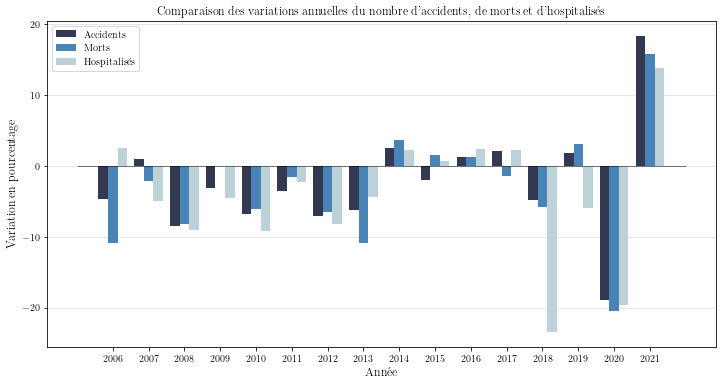

In [18]:
palette = cmr.take_cmap_colors('cmr.arctic', 3, cmap_range=(0.25, 0.85), return_fmt='hex')

fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(x='an', y='var_pourc', data=df_var_pourc.reset_index(), hue='categorie', palette=palette, ax=ax)
plt.hlines(0,-1,16, color='black', linewidth=0.5)
plt.title("Comparaison des variations annuelles du nombre d'accidents, de morts et d'hospitalisés", size=12)
plt.xlabel("Année", size=12)
plt.ylabel("Variation en pourcentage", size=12)
handles, labels = plt.gca().get_legend_handles_labels()  # récupération des handles et labels de la légende
labels = ['Accidents', 'Morts', 'Hospitalisés']   # changement des labels de la légende
plt.legend(handles, labels, title="")
plt.grid(visible=True, axis='y', color="#e0e0e0")
ax.set_axisbelow(True)
plt.show()

Le nombre de blessés hospitalisés et le nombre de morts ont à peu près suivi la même évolution que le nombre d'accidents. A partir 2018, un changement de processus de saisie des données sur les blessés hospitalisés fait que le nombre de d'hospitalisés ne peut pas être comparé avec les années précédentes. On remarque d'ailleurs une variation très différente de celles des nombres d'accidents en 2018 et 2019. Cela a peut-être un rapport avec ce changement de processus.


On peut vérifier s'il y a corrélation linéaire entre nombre de morts (resp. d'hospitalisés) et nombre d'accidents. Ce n'est pas a priori évident car les mesures prises par les autorités publiques, les améliorations d'équipements de sécurité des véhicules ainsi que des aménagements routiers pourraient faire chuter le nombre de morts ou de blessés graves plus vite que le nombre d'accidents.

### 2.1.2. Y-a-t-il eu corélation entre nombre de morts (resp. de blessés hospitalisés) et le nombre d'accidents entre 2005 et 2021 ?

- **Corrélation nombre de morts/nombre d'accidents**

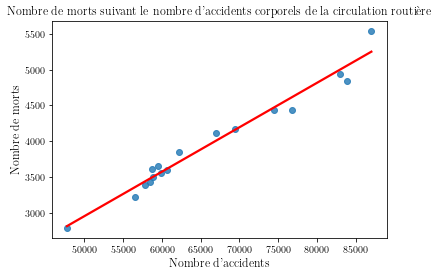

In [19]:
morts_vs_acc = pd.DataFrame(acc_par_an['Effectif']).rename(columns={'Effectif':'Accidents'})
morts_vs_acc['Morts'] = morts_par_an['Effectif'].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6,4))

sns.regplot(x='Accidents', y='Morts', data=morts_vs_acc, ci=None, line_kws={'color':'red'})
plt.xlabel("Nombre d'accidents", size=12)
plt.ylabel("Nombre de morts", size=12)
plt.title("Nombre de morts suivant le nombre d'accidents corporels de la circulation routière", size=12)
im = plt.gcf()
im.savefig('img/corr_acc_morts.png', dpi=200, bbox_inches="tight")
plt.show()

Il semble y avoir une corrélation linéaire entre les deux variables. Regardons la normalité des deux variables.

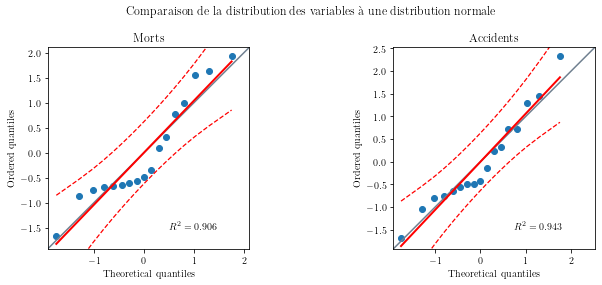

In [20]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(10,4))
pingouin.qqplot(morts_vs_acc['Accidents'], dist='norm', color='tab:blue', ax=ax1)
ax1.set_title('Morts')
pingouin.qqplot(morts_vs_acc['Morts'], dist='norm', color='tab:blue', ax=ax2)
ax2.set_title('Accidents')
plt.suptitle('Comparaison de la distribution des variables à une distribution normale')
fig.tight_layout()
im = plt.gcf()
im.savefig('img/qq_acc_morts.png', dpi=200, bbox_inches="tight")
plt.show()

Les variables ne suivent pas une distribution normale. Nous allons faire un test de corrélation de Spearman :
- Hypothèse nulle $H_0$ : pas de corrélation entre les variables (coefficient de corrélation nul)
- Hypothèse alternative $H_1$ : corrélation positive (coefficient de corrélation positif et significativement différent de 0) -> test unilatéral
- Seuil de signification $\alpha=0,05$

In [21]:
pingouin.corr(morts_vs_acc['Morts'], morts_vs_acc['Accidents'], alternative='greater', method='spearman')

,n,r,CI95%,p-val,power
spearman,17,0.969957,"[0.93, 1.0]",6.438087e-11,1.0


Le test de Spearman indique que les deux variables sont significativement corrélées ($\small p<0.0001^{***}$). La corrélation est très forte : $\small\rho = 0,97$.

- **Corrélation nombre d'hospitalisés/nombre d'accidents**

Uniquement sur les données pré-2018 à cause du changement dans la saisie des données en 2018.

In [22]:
# Dataframe hospitalisés vs accidents
hosp_vs_acc = pd.DataFrame(acc_par_an.loc[acc_par_an['an']<2018,'Effectif']).rename(columns={'Effectif':'Accidents'})
hosp_vs_acc['Hospitalisés'] = hosp_par_an.loc[hosp_par_an['an']<2018,'Effectif'].reset_index(drop=True)

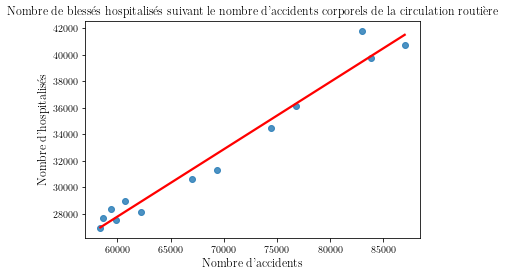

In [23]:
fig, ax = plt.subplots(figsize=(6,4))

sns.regplot(x=acc_par_an.loc[acc_par_an['an']<2018,'Effectif'], y=hosp_par_an.loc[hosp_par_an['an']<2018,'Effectif'], ci=None, line_kws={'color':'red'})
plt.xlabel("Nombre d'accidents", size=12)
plt.ylabel("Nombre d'hospitalisés", size=12)
plt.title("Nombre de blessés hospitalisés suivant le nombre d'accidents corporels de la circulation routière", size=12)
im = plt.gcf()
im.savefig('img/corr_acc_bl.png', dpi=200, bbox_inches="tight")
plt.show()

Il semble y avoir une bonne corrélation positive entre les deux variables. On sait que le nombre d'accidents ne suit pas une distribution normale donc faisons un test de corrélation de Spearman :

- Hypothèse nulle $H_0$ : pas de corrélation entre les variables (coefficient de corrélation nul)
- Hypothèse alternative $H_1$ : corrélation positive (coefficient de corrélation positif et significativement différent de 0) -> test unilatéral
- Seuil de signification $\alpha=0,05$

In [24]:
pingouin.corr(hosp_vs_acc['Hospitalisés'], hosp_vs_acc['Accidents'], alternative='greater', method='spearman')

,n,r,CI95%,p-val,power
spearman,13,0.945055,"[0.85, 1.0]",5.619656e-07,0.999982


Le test de Spearman indique que les deux variables sont significativement corrélées ($\small p<0.0001^{***}$). La corrélation est très forte : $\small\rho = 0,95$.

### 2.1.2. Les proportions de blessés légers, hospitalisés et morts restent-ils constants au fil des années ?

In [25]:
pourc_par_grav = gravite_par_an.divide(gravite_par_an.sum(axis=1), axis=0)*100
pourc_par_grav

grav,Indemne,Tué,Hospitalisé,Bléssé léger
an,,,,
2005,40.633510,2.811037,20.670734,35.884719
2006,40.696411,2.644327,22.376683,34.282579
2007,40.787838,2.569798,21.106777,35.535587
2008,40.700727,2.601359,21.162995,35.534919
2009,40.828592,2.679105,20.807714,35.684590
2010,40.739105,2.709144,20.328967,36.222784
2011,40.773579,2.768364,20.626975,35.831082
2012,40.794206,2.774448,20.283366,36.147980
2013,40.905061,2.664323,20.900084,35.530532


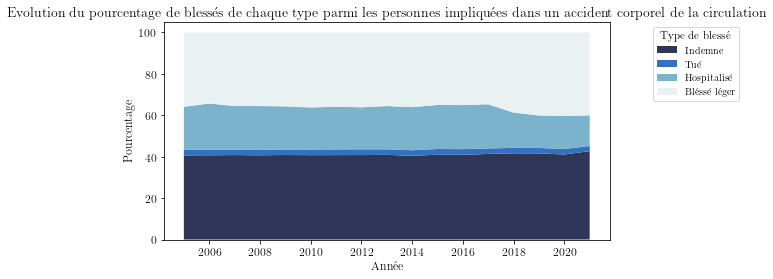

In [26]:
#choix des couleurs
couleurs = cmr.take_cmap_colors('cmr.arctic', 4, cmap_range=(0.25, 0.95), return_fmt='hex')

fig,ax = plt.subplots(figsize=(8,4))
plt.stackplot(pourc_par_grav.index, pourc_par_grav.transpose(), labels=pourc_par_grav.columns, colors=couleurs)

#Mise en forme des axes, titre et légende
plt.title('Evolution du pourcentage de blessés de chaque type parmi les personnes impliquées dans un accident corporel de la circulation', fontsize=14)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Pourcentage', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Type de blessé', bbox_to_anchor=[1.3,1], fontsize=10, title_fontsize=11)
plt.show()

Les proportions restent à peu près les mêmes à part une baisse du pourcentage d'hospitalisés au profit du pourcentage de blessés légers entre 2017 et 2019.

## 2.2 Existe-t-il des mois plus accidentogènes que d'autres ?

### 2.2.1. Calcul du nombre moyen d'accidents pour chaque mois de l'année sur la période 2005-2017

L'année 2020 étabnt particulière avec des mois de confinement, elle est retirée de cette partie de l'étude.

In [27]:
# Nombre d'accidents par année et par mois
acc_par_mois = (df_caract.loc[df_caract['an']!=2020]
                .groupby(['an','mois'])
                .agg(Effectif = pd.NamedAgg('Num_Acc','count'))
                .reset_index())
acc_par_mois.head()

,an,mois,Effectif
0,2005,1,7125
1,2005,2,5568
2,2005,3,6569
3,2005,4,6618
4,2005,5,7832


In [28]:
acc_par_mois['Effectif'].describe()

count     192.000000
mean     5592.848958
std      1052.849076
min      3350.000000
25%      4832.000000
50%      5409.500000
75%      6234.250000
max      8469.000000
Name: Effectif, dtype: float64

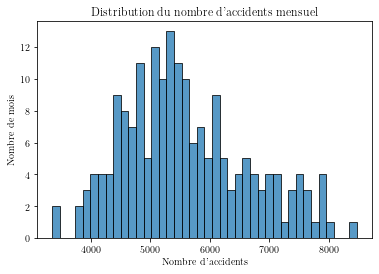

In [29]:
fig, ax= plt.subplots(figsize=(6,4))
sns.histplot(x='Effectif', data=acc_par_mois, bins=40)
plt.xlabel("Nombre d'accidents")
plt.ylabel("Nombre de mois")
plt.title("Distribution du nombre d'accidents mensuel")
plt.show()

In [30]:
# Moyenne par mois
moy_par_mois = (acc_par_mois
                .groupby('mois')
                .agg(moyenne = pd.NamedAgg('Effectif','mean'),
                     mediane = pd.NamedAgg('Effectif','median'),
                     variance = pd.NamedAgg('Effectif','var'),
                     std = pd.NamedAgg('Effectif','std'))
                .reset_index()
               )
moy_par_mois

,mois,moyenne,mediane,variance,std
0,1,5098.9375,4792.5,880131.262500,938.153113
1,2,4485.3750,4255.0,646608.383333,804.119632
2,3,5231.5000,5150.5,788831.466667,888.161847
3,4,5364.5000,5039.5,866269.600000,930.736053
4,5,5779.1875,5303.0,953666.295833,976.558393
5,6,6324.5625,5870.5,973471.062500,986.646372
6,7,5995.8125,5543.0,868710.962500,932.046653
7,8,5015.3750,4568.0,614245.050000,783.737871
8,9,6173.5000,5758.0,799352.933333,894.065397
9,10,6374.3125,5940.5,992176.362500,996.080500


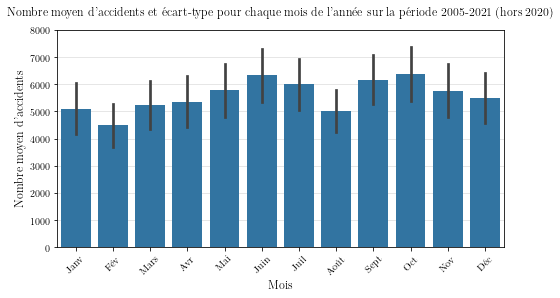

In [31]:
# Représentation graphique du nombre d'accidents moyen par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='mois', y='Effectif', data= acc_par_mois, color='tab:blue', errorbar='sd')
plt.ylim(0,8000)
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre moyen d'accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Nombre moyen d'accidents et écart-type pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12, y=1.04)
ax.set_axisbelow(True)
im = plt.gcf()
im.savefig('img/acc_mens_moy.png', dpi=200, bbox_inches="tight")
plt.show()

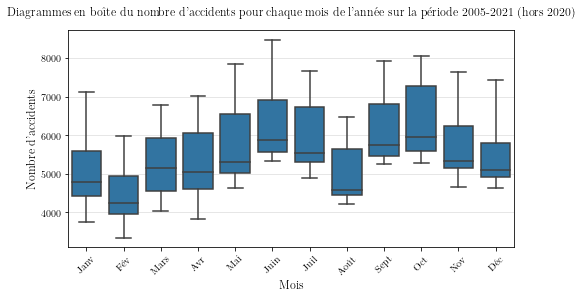

In [32]:
# boxplot du nombre d'accidents par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='mois', y='Effectif', data= acc_par_mois, color='tab:blue', whis=[0,100])
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre d'accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Diagrammes en boîte du nombre d'accidents pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12, y=1.04)
ax.set_axisbelow(True)
im = plt.gcf()
im.savefig('img/acc_mens_med.png', dpi=200, bbox_inches="tight")
plt.show()

On remarque que les mois de juin, septembre et octobre ont été les plus accidentogènes, février étant le mois le moins accidentogène. Mais ces différence sont-elles significatives ? Pour répondre, nous pouvons voir s'il est possible de réaliser une ANOVA.

### 2.2.2. ANOVA

In [33]:
#Définition d'une fonction d'affichage de graphiques de diagnostics d'un modèle

def diagnostic_plots(fitted, resid, norm_resid, leverage, alpha=0.5):
    """Fonction qui affiche les graphiques de diagnostic d'un modèle:
    - residus vs valeurs prédites
    - qqplot résidus vs distribution normale
    - scale location
    - résidus vs effet de levier
    
    paramètres :
    - fitted : valeurs prédites
    - resid : résidus
    - norm_resid : résidus normalisés
    - leverage : effet de levier
    - alpha : opacité des points (défaut=0.5)
    """
    
    #racine carrée des résidus standardisés
    resid_sqrt = np.sqrt(np.abs(norm_resid))
    
    # Graphiques de diagnostic d'un
    fig,((ax00, ax01), (ax10,ax11)) = plt.subplots(2,2,figsize=(7,7))

    sns.regplot(x=fitted, y=resid, lowess=True, line_kws={'color':'red'}, scatter_kws={'alpha':alpha}, ax=ax00)
    ax00.set_title('Résidus en fonction des valeurs prédites', size=10)
    ax00.set_xlabel('Valeurs prédites')
    ax00.set_ylabel('Résidus')

    pingouin.qqplot(resid, dist='norm', color='tab:blue', ax=ax01)
    ax01.set_title('Q-Q plot de comparaison à une distribution normale', size=10)
    ax01.set_xlabel('Quantiles de la distribution normale')
    ax01.set_ylabel('Quantiles des résidus')

    sns.regplot(x=fitted, y=resid_sqrt, lowess=True, line_kws={'color':'red'}, scatter_kws={'alpha':alpha}, ax=ax10)
    ax10.set_title('Scale-location', size=10)
    ax10.set_xlabel('Valeurs prédites')
    ax10.set_ylabel('Racine carrée des résidus standardisés')

    sns.regplot(x=leverage, y=resid_sqrt, lowess=True, line_kws={'color':'red'}, scatter_kws={'alpha':alpha}, ax=ax11)
    ax11.set_title('Résidus vs effet de levier', size=10)
    ax11.set_xlabel('Effet de levier')
    ax11.set_ylabel('Résidus standardisés')

    plt.tight_layout()
    plt.show()


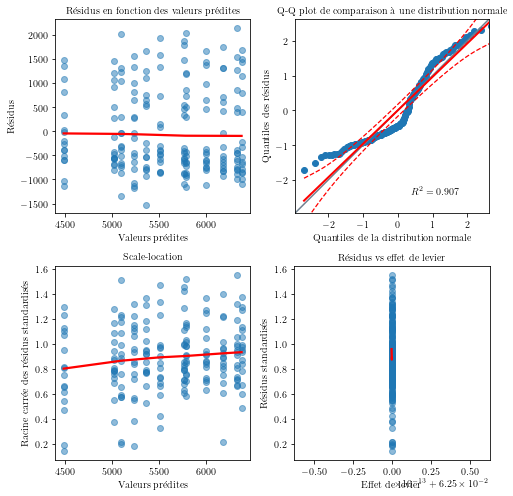

In [34]:
model_lin_acc_mois = ols("Effectif ~ C(mois)", data=acc_par_mois).fit()


# Valeurs prédites
fitted_lm = model_lin_acc_mois.fittedvalues
# Résidus
residus_lm = model_lin_acc_mois.resid
#residus standardisés et leur racine carrée
influence_lm = model_lin_acc_mois.get_influence()
residus_norm_lm = influence_lm.resid_studentized_internal
#effet de levier
leverage_lm = influence_lm.hat_matrix_diag

# Graphiques de diagnostic
diagnostic_plots(fitted_lm, residus_lm, residus_norm_lm, leverage_lm)

On constate que les résidus ne suivent pas une distribution normale mais nous prendrons le parti qu'il sont suffisamment proches d'une distribution normale pour réaliser une ANOVA. 

ANOVA :

- Hypothèse nulle $\small H_0$ : le nombre moyen d'accidents est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre moyen est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [35]:
anova_table = sm.stats.anova_lm(model_lin_acc_mois, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(mois),5.928142e+07,11.0,6.363534,7.298885e-09
Residual,1.524404e+08,180.0,NaN,NaN


L'ANOVA permet de rejeter l'hypothèse nulle au risque de 5% : $\small F(11,\,180)=6.37$, $\small p<0.0001^{***}$. On en conclut qu'il y a une différence significative du nombre moyen d'accidents suivant le mois.

### 2.2.3 Test de Kruskal-Wallis

Compte-tenu de la non normalité des résidus du modèle linéaire, un test non paramétrique de Kruskal-Wallis est plus adapté qu'une ANOVA.

- Hypothèse nulle $\small H_0$ : le nombre médian d'accidents est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre médian est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [36]:
liste_groupes = []
# Pour chaque mois, on crée une liste du nombre d'accidents sur les années 2005-2021 (hors 2020)
for i in range(1,13):
    df = acc_par_mois.loc[acc_par_mois['mois']==i]
    liste_groupes.append(df['Effectif'].tolist())

In [37]:
stats.kruskal(liste_groupes[0], liste_groupes[1], liste_groupes[2],
             liste_groupes[3], liste_groupes[4], liste_groupes[5],
             liste_groupes[6], liste_groupes[7], liste_groupes[8],
             liste_groupes[9], liste_groupes[10], liste_groupes[11])

KruskalResult(statistic=56.59406297473406, pvalue=3.951928213444532e-08)

Le test de Kruskal-Wallis permet de rejeter l'hypothèse $\small H_0$ au risque de 5% : $\chi^2(11)=56.59, p<0.001^{***}$. Le nombre médian d'accidents est différent suivant le mois de l'année.

### 2.2.4. Comparaison multiple
Comparaisons multiples des mois deux à deux.

In [38]:
multicomp_mois = multi.MultiComparison(acc_par_mois['Effectif'], acc_par_mois['mois'])

# Effectuer le test post-hoc de Tukey
result = multicomp_mois.tukeyhsd()

# Afficher les résultats
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     1      2  -613.5625 0.7665  -1691.042   463.917  False
     1      3   132.5625    1.0   -944.917  1210.042  False
     1      4   265.5625 0.9996   -811.917  1343.042  False
     1      5     680.25   0.63  -397.2295 1757.7295  False
     1      6   1225.625 0.0117   148.1455 2303.1045   True
     1      7    896.875 0.2082  -180.6045 1974.3545  False
     1      8   -83.5625    1.0  -1161.042   993.917  False
     1      9  1074.5625 0.0513     -2.917  2152.042  False
     1     10   1275.375 0.0068   197.8955 2352.8545   True
     1     11    667.875 0.6567  -409.6045 1745.3545  False
     1     12    405.375 0.9843  -672.1045 1482.8545  False
     2      3    746.125 0.4853  -331.3545 1823.6045  False
     2      4    879.125  0.234  -198.3545 1956.6045  False
     2      5  1293.8125 0.0056    216.3

## 2.3. Y-a-t-il des mois plus meurtriers que d'autres ?
### 2.3.1. Calcul du nombre moyen de morts pour chaque mois de l'année sur la période 2005-2021

In [39]:
# Nombre de morts par année et par mois
morts_par_mois = (df_usagers.loc[df_usagers['grav']==2, ['Num_Acc']]
                  .merge(df_caract.loc[df_caract['an']!=2020, ['Num_Acc', 'an', 'mois']], how='inner', left_on='Num_Acc', right_on='Num_Acc')
                  .groupby(['an','mois'])
                  .agg(Effectif = pd.NamedAgg('Num_Acc','count'))
                  .reset_index()
                 )
morts_par_mois.head()

,an,mois,Effectif
0,2005,1,426
1,2005,2,368
2,2005,3,406
3,2005,4,389
4,2005,5,470


In [40]:
morts_par_mois['Effectif'].describe()

count    192.000000
mean     334.734375
std       70.436911
min      187.000000
25%      287.750000
50%      327.000000
75%      371.250000
max      631.000000
Name: Effectif, dtype: float64

335 morts par mois en moyenne sur la période 2005-2017 (hors année 2020)

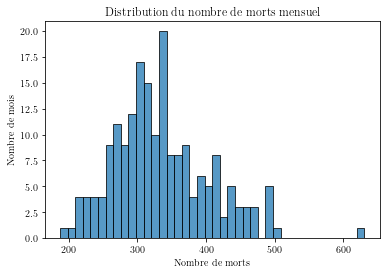

In [41]:
fig, ax= plt.subplots(figsize=(6,4))
sns.histplot(x='Effectif', data=morts_par_mois, bins=40)
plt.xlabel("Nombre de morts")
plt.ylabel("Nombre de mois")
plt.title("Distribution du nombre de morts mensuel")
plt.show()

On remarque un outlier. Regardons à quel mois il correspond.

In [42]:
morts_par_mois.loc[morts_par_mois['Effectif']==morts_par_mois['Effectif'].max()]

,an,mois,Effectif
6,2005,7,631


Il s'agit de juillet 2005. Après recherche sur internet, il n'apparaît pas de raison particulière.

In [43]:
# Moyenne par mois
moy_morts_mois = (morts_par_mois
                .groupby('mois')
                .agg(moyenne = pd.NamedAgg('Effectif','mean'),
                     mediane = pd.NamedAgg('Effectif','median'),
                     variance = pd.NamedAgg('Effectif','var'),
                     std = pd.NamedAgg('Effectif','std'))
                .reset_index()
               )
moy_morts_mois

,mois,moyenne,mediane,variance,std
0,1,298.6250,281.0,3896.116667,62.418881
1,2,265.1875,268.0,2095.762500,45.779499
2,3,294.1250,288.0,3036.516667,55.104598
3,4,309.0625,293.0,3473.662500,58.937785
4,5,328.6250,322.5,4596.783333,67.799582
5,6,347.2500,327.5,3212.466667,56.678626
6,7,407.3750,373.5,6393.450000,79.959052
7,8,362.3125,347.5,4225.962500,65.007403
8,9,356.1875,341.0,2954.295833,54.353434
9,10,370.3750,355.5,4270.783333,65.351231


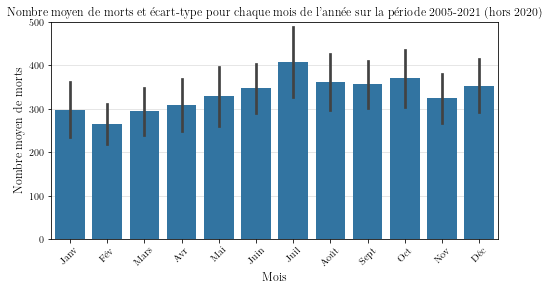

In [44]:
# Représentation graphique du nombre d'accidents moyen par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='mois', y='Effectif', data= morts_par_mois, color='tab:blue', errorbar='sd')
plt.ylim(0,500)
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre moyen de morts", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Nombre moyen de morts et écart-type pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

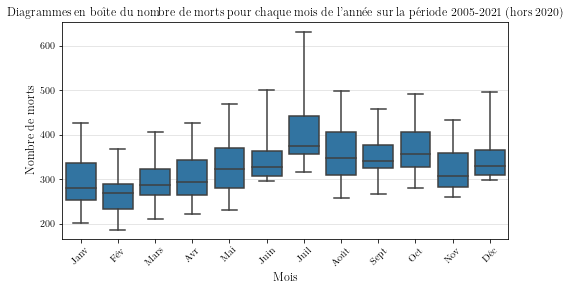

In [45]:
# boxplot du nombre de morts par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='mois', y='Effectif', data= morts_par_mois, color='tab:blue', whis=[0,100])
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre de morts", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Diagrammes en boîte du nombre de morts pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

Résultats intéressants : 
- Alors que le mois de juillet ne se classe que 4ème en nombre moyen d'accidents, c'est le mois le plus meurtrier.
- Le mois d'août est un des mois avec le plus faible nombre moyen d'accidents mais un des plus hauts nombres moyens de morts.

Regardons si les différences observées entre mois sont significatives.

### 2.3.2 ANOVA

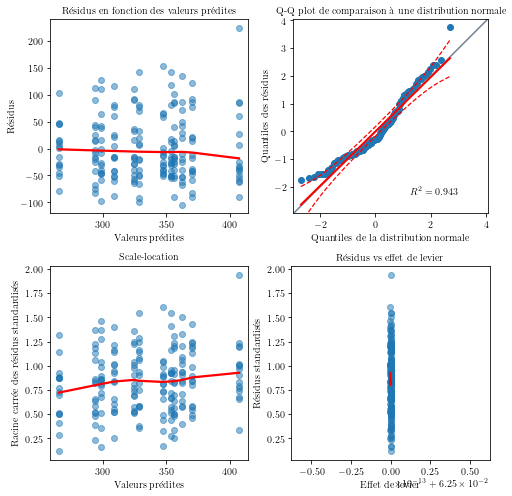

In [46]:
model_lin_morts_mois = ols("Effectif ~ C(mois)", data=morts_par_mois).fit()


# Valeurs prédites
fitted_lm = model_lin_morts_mois.fittedvalues
# Résidus
residus_lm = model_lin_morts_mois.resid
#residus standardisés et leur racine carrée
influence_lm = model_lin_morts_mois.get_influence()
residus_norm_lm = influence_lm.resid_studentized_internal
#effet de levier
leverage_lm = influence_lm.hat_matrix_diag

# Graphiques de diagnostic
diagnostic_plots(fitted_lm, residus_lm, residus_norm_lm, leverage_lm)

Là-encore, les résidus ne suivent pas une loi normale mais nous considérerons que nous pouvons faire une ANOVA :

- Hypothèse nulle $\small H_0$ : le nombre moyen de morts est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre moyen est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [47]:
anova_table_morts = sm.stats.anova_lm(model_lin_morts_mois, typ=2)
anova_table_morts

,sum_sq,df,F,PR(>F)
C(mois),269865.265625,11.0,6.515603,4.308671e-09
Residual,677754.187500,180.0,NaN,NaN


L'ANOVA permet de rejeter l'hypothèse nulle au risque de 5% : $\small F(11,\,180)=6.52$, $\small p<0.0001^{***}$. On en conclut qu'il y a une différence significative du nombre moyen de morts suivant le mois.

### 2.3.3. Test de Kruskal-Wallis

- Hypothèse nulle $\small H_0$ : le nombre médian de morts est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre médian est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [48]:
liste_groupes = []
# Pour chaque mois, on crée une liste du nombre de morts sur les années 2005-2021 (hors 2020)
for i in range(1,13):
    df = morts_par_mois.loc[morts_par_mois['mois']==i]
    liste_groupes.append(df['Effectif'].tolist())

In [49]:
stats.kruskal(liste_groupes[0], liste_groupes[1], liste_groupes[2],
             liste_groupes[3], liste_groupes[4], liste_groupes[5],
             liste_groupes[6], liste_groupes[7], liste_groupes[8],
             liste_groupes[9], liste_groupes[10], liste_groupes[11])

KruskalResult(statistic=57.45443794049504, pvalue=2.74375436692588e-08)

Le test de Kruskal-Wallis permet de rejeter l'hypothèse nulle au risque de 5% : $\small \chi^2(11) = 57.45, p<0.0001^{***}$. Le nombre médian de morts diffère suivant les mois de l'année.

### 2.3.4. Comparaisons multiples

In [50]:
multicomp_mois = multi.MultiComparison(morts_par_mois['Effectif'], morts_par_mois['mois'])

# Effectuer le test post-hoc de Tukey
result = multicomp_mois.tukeyhsd()

# Afficher les résultats
print(result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     1      2 -33.4375 0.9269 -105.2823  38.4073  False
     1      3     -4.5    1.0  -76.3448  67.3448  False
     1      4  10.4375    1.0  -61.4073  82.2823  False
     1      5     30.0 0.9655  -41.8448 101.8448  False
     1      6   48.625 0.5222  -23.2198 120.4698  False
     1      7   108.75 0.0001   36.9052 180.5948   True
     1      8  63.6875 0.1375   -8.1573 135.5323  False
     1      9  57.5625 0.2588  -14.2823 129.4073  False
     1     10    71.75 0.0506   -0.0948 143.5948  False
     1     11  25.6875 0.9896  -46.1573  97.5323  False
     1     12    54.75 0.3323  -17.0948 126.5948  False
     2      3  28.9375 0.9735  -42.9073 100.7823  False
     2      4   43.875 0.6776  -27.9698 115.7198  False
     2      5  63.4375 0.1414   -8.4073 135.2823  False
     2      6  82.0625 0.0111   10.2177 153.9073

## 2.4. Comparaison du taux de mortalité

Le fait que l'on observe des mois avec "peu d'accidents" et un grand nombre de morts pousse à calculer le taux de mortalité que nous définirons de la manière suivante :

**taux de mortalité = nombre de morts pour 100 accidents**

Nous utiliserons ce calcul plutôt que le pourcentage d'accidents mortels parmi les accidents corporels car il peut y avoir plusieurs morts lors d'un accident.

### 2.4.1. Calcul des taux de mortalité

In [51]:
#jointure acc_par_mois et morts_par_mois
acc_vs_morts_par_mois = (acc_par_mois
                         .rename(columns={'Effectif':'accidents'})
                         .merge(morts_par_mois.rename(columns={'Effectif':'morts'}), how='inner', on=['an','mois'])
                        )
acc_vs_morts_par_mois.head()

,an,mois,accidents,morts
0,2005,1,7125,426
1,2005,2,5568,368
2,2005,3,6569,406
3,2005,4,6618,389
4,2005,5,7832,470


In [52]:
# Calcul du taux de mortalité
acc_vs_morts_par_mois['tx_mort'] = acc_vs_morts_par_mois['morts']/acc_vs_morts_par_mois['accidents']*100
acc_vs_morts_par_mois.head()

,an,mois,accidents,morts,tx_mort
0,2005,1,7125,426,5.978947
1,2005,2,5568,368,6.609195
2,2005,3,6569,406,6.180545
3,2005,4,6618,389,5.877909
4,2005,5,7832,470,6.001021


In [53]:
# Taux de mortalité moyen pour chaque mois de l'année
(acc_vs_morts_par_mois
 .groupby('mois')
 .agg(taux_moyen = pd.NamedAgg('tx_mort','mean'),
      taux_median = pd.NamedAgg('tx_mort','median'),
      variance = pd.NamedAgg('tx_mort','var'),
      std = pd.NamedAgg('tx_mort','std'))
)

,taux_moyen,taux_median,variance,std
mois,,,,
1,5.843077,5.809016,0.168947,0.411032
2,5.940371,6.054802,0.304039,0.551398
3,5.619113,5.605510,0.161878,0.402340
4,5.755641,5.742661,0.107171,0.327369
5,5.663005,5.783013,0.187471,0.432979
6,5.498642,5.515094,0.121844,0.349062
7,6.777223,6.634188,0.260464,0.510357
8,7.215034,7.348224,0.294118,0.542327
9,5.775850,5.860158,0.158728,0.398407


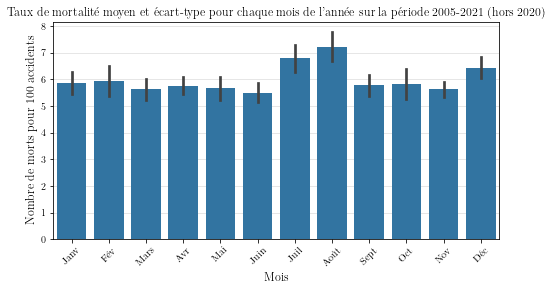

In [164]:
# Représentation graphique du taux de mortalité moyen par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='mois', y='tx_mort', data= acc_vs_morts_par_mois, color='tab:blue', errorbar='sd')
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre de morts pour 100 accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Taux de mortalité moyen et écart-type pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
im = plt.gcf()
im.savefig('img/tx_mort_mois_moy.png', dpi=200, bbox_inches="tight")
plt.show()

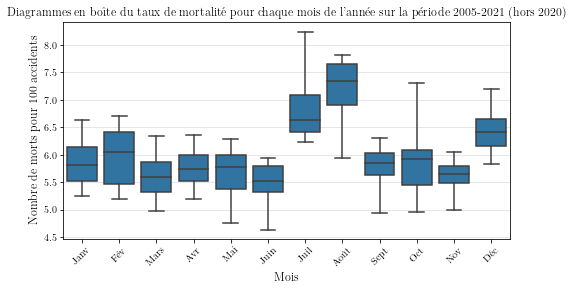

In [165]:
# boxplot du taux de mortalité par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='mois', y='tx_mort', data= acc_vs_morts_par_mois, color='tab:blue', whis=[0,100])
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre de morts pour 100 accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Diagrammes en boîte du taux de mortalité pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
im = plt.gcf()
im.savefig('img/tx_mort_mois_med.png', dpi=200, bbox_inches="tight")
plt.show()

On voit clairement trois mois avec des taux de mortalité supérieurs aux autres : juillet, août et décembre. On peut avancer les hyptohèses des départs en vacances. Testons si les différences observées sont significatives.

### 2.4.2. ANOVA

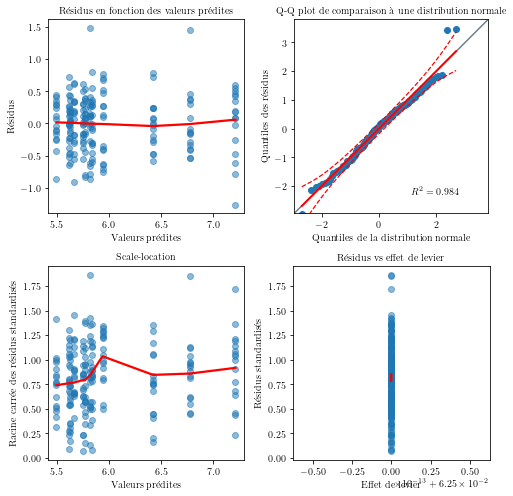

In [56]:
model_lin_tx_mort = ols("tx_mort ~ C(mois)", data=acc_vs_morts_par_mois).fit()


# Valeurs prédites
fitted_lm = model_lin_tx_mort.fittedvalues
# Résidus
residus_lm = model_lin_tx_mort.resid
#residus standardisés et leur racine carrée
influence_lm = model_lin_tx_mort.get_influence()
residus_norm_lm = influence_lm.resid_studentized_internal
#effet de levier
leverage_lm = influence_lm.hat_matrix_diag

# Graphiques de diagnostic
diagnostic_plots(fitted_lm, residus_lm, residus_norm_lm, leverage_lm)

Mis à part deux résidus, les résidus suivent approximativement une loi normale et l'homoscédasticité est relativement bonne. Nous considèrerons que nous sommes dans des conditions valides d'utilisation d'une ANOVA

- Hypothèse nulle $\small H_0$ : le taux de mortalité est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le taux de mortalité est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [57]:
anova_tx_mort = sm.stats.anova_lm(model_lin_tx_mort, typ=2)
anova_tx_mort

,sum_sq,df,F,PR(>F)
C(mois),49.344079,11.0,23.177844,4.165712e-29
Residual,34.837087,180.0,NaN,NaN


L'ANOVA permet de rejeter l'hypothèse nulle : $\small F(11, 180) = 23.18, p<0.000^{***}$. On en déduit qu'il y a une différence significative entre les taux de mortalités des différents mois de l'année. Le text de Tuckey devrait nous montrer qu'il y a une déifférence significative entre les mois de juillet, août et décembre d'un côté, et les autres mois de l'autre côté.

### 2.4.3. Test de Tuckey

In [58]:
multicomp_mois = multi.MultiComparison(acc_vs_morts_par_mois['tx_mort'], acc_vs_morts_par_mois['mois'])

# Effectuer le test post-hoc de Tukey
result = multicomp_mois.tukeyhsd()

# Afficher les résultats
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0973    1.0 -0.4178  0.6124  False
     1      3   -0.224 0.9539 -0.7391  0.2911  False
     1      4  -0.0874    1.0 -0.6025  0.4277  False
     1      5  -0.1801 0.9913 -0.6952   0.335  False
     1      6  -0.3444 0.5415 -0.8595  0.1707  False
     1      7   0.9341    0.0  0.4191  1.4492   True
     1      8    1.372    0.0  0.8569   1.887   True
     1      9  -0.0672    1.0 -0.5823  0.4479  False
     1     10  -0.0258    1.0 -0.5409  0.4893  False
     1     11  -0.2194 0.9602 -0.7345  0.2957  False
     1     12    0.582 0.0128  0.0669  1.0971   True
     2      3  -0.3213 0.6478 -0.8363  0.1938  False
     2      4  -0.1847 0.9893 -0.6998  0.3304  False
     2      5  -0.2774  0.825 -0.7925  0.2377  False
     2      6  -0.4417 0.1726 -0.9568  0.0734  False
     2      7   0.8369    0.0  0.3218  1.3519 

- Le taux de mortalité de juillet est significativement différent de celui de tous les autres mois de l'année à l'exception de août et décembre ($\small p<0.0001^{***}$ à chaque fois)
- Le taux de mortalité d'août est significativement différent de celui de tous les autres mois de l'année à l'exception de juillet uniquement ($\small p<0.0001^{***}$ à chaque fois)
- Le taux de mortalité de décembre est significativement différent de celui de tous les autres mois de l'année à l'exception de juillet, août et février.

## 2.5. Taux de mortalité suivant le jour de la semaine.

### 2.5.1 Calcul du taux de mortalité chaque jour

Les taux de mortalité élevés aux mois de juillet, août et décembre amènent à se poser la question de leur cause. Une hyptohèse est un taux de mortalité élevé lors des week-ends de départ en vacances. Mais il faut aussi regarder les taux de mortalités le week-end les autres mois. En effet, si on observe une élévation du taux de mortalité le week-end en juillet et août mais également les autres mois, celà ne permettra pas de conclure en l'influence des week-ends de départ en vacances.

Pour étudier ces taux, il faut créer une variable date et y faire correspondre le jour de la semaine.



In [59]:
# Création de la variable date
df_caract['date'] = pd.to_datetime(df_caract[['an','mois','jour']].rename(columns={'an':'year', 'mois':'month', 'jour':'day'}))
df_caract[['an','mois','jour','date']].head()

,an,mois,jour,date
0,2019,11,30,2019-11-30
1,2019,11,30,2019-11-30
2,2019,11,28,2019-11-28
3,2019,11,30,2019-11-30
4,2019,11,30,2019-11-30


In [60]:
# Création du jour de la semaine
df_caract['nom_jour'] = df_caract['date'].dt.day_name(locale='fr_FR.utf8')
df_caract['nom_mois'] = df_caract['date'].dt.month_name(locale='fr_FR.utf8')
df_caract[['an','mois','jour','date','nom_jour', 'nom_mois']].head()

,an,mois,jour,date,nom_jour,nom_mois
0,2019,11,30,2019-11-30,Samedi,Novembre
1,2019,11,30,2019-11-30,Samedi,Novembre
2,2019,11,28,2019-11-28,Jeudi,Novembre
3,2019,11,30,2019-11-30,Samedi,Novembre
4,2019,11,30,2019-11-30,Samedi,Novembre


In [61]:
acc_par_jour = (df_caract
                .groupby(['an','mois','nom_mois','nom_jour'])
                .agg(accidents = pd.NamedAgg('Num_Acc','count'))
                .reset_index()
                )
acc_par_jour.head()

,an,mois,nom_mois,nom_jour,accidents
0,2005,1,Janvier,Dimanche,763
1,2005,1,Janvier,Jeudi,992
2,2005,1,Janvier,Lundi,1127
3,2005,1,Janvier,Mardi,1021
4,2005,1,Janvier,Mercredi,1070


In [62]:
morts_par_jour = (df_caract[['Num_Acc','an','mois','jour','date','nom_jour']]
                  .merge(df_usagers.loc[df_usagers['grav']==2], on='Num_Acc', how='inner')
                  .groupby(['an','mois','nom_jour'])
                  .agg(morts = pd.NamedAgg('Num_Acc','count'))
                  .reset_index()
                 )
morts_par_jour.head()

,an,mois,nom_jour,morts
0,2005,1,Dimanche,76
1,2005,1,Jeudi,41
2,2005,1,Lundi,49
3,2005,1,Mardi,57
4,2005,1,Mercredi,54


Nous pouvons maintenant étudier le taux de mortalité pour chaque jour de la semaine et pour chaque mois de l'année.

In [63]:
acc_vs_morts_par_jour = acc_par_jour.merge(morts_par_jour, on=['an','mois','nom_jour'], how='inner')
acc_vs_morts_par_jour['tx_mortalite'] = acc_vs_morts_par_jour['morts']/acc_vs_morts_par_jour['accidents']*100
acc_vs_morts_par_jour.head()

,an,mois,nom_mois,nom_jour,accidents,morts,tx_mortalite
0,2005,1,Janvier,Dimanche,763,76,9.960682
1,2005,1,Janvier,Jeudi,992,41,4.133065
2,2005,1,Janvier,Lundi,1127,49,4.347826
3,2005,1,Janvier,Mardi,1021,57,5.582762
4,2005,1,Janvier,Mercredi,1070,54,5.046729


In [64]:
acc_vs_morts_pivot = round(acc_vs_morts_par_jour.pivot_table(index='mois', columns='nom_jour', values='tx_mortalite', aggfunc='mean'), 1)
acc_vs_morts_pivot

nom_jour,Dimanche,Jeudi,Lundi,Mardi,Mercredi,Samedi,Vendredi
mois,,,,,,,
1,8.8,4.9,5.1,5.4,5.3,7.1,5.4
2,7.9,5.2,5.4,5.2,4.9,7.5,5.7
3,8.7,4.7,4.6,5.0,4.5,7.4,5.5
4,8.9,5.3,5.7,4.8,4.5,7.5,5.5
5,8.2,5.3,5.7,4.2,4.9,6.9,5.4
6,7.7,4.8,5.1,4.4,5.0,6.9,5.0
7,8.7,6.0,5.9,5.8,6.1,8.0,6.8
8,9.5,6.3,6.6,6.3,6.3,8.2,6.7
9,8.2,4.9,5.1,5.0,4.8,7.4,5.5


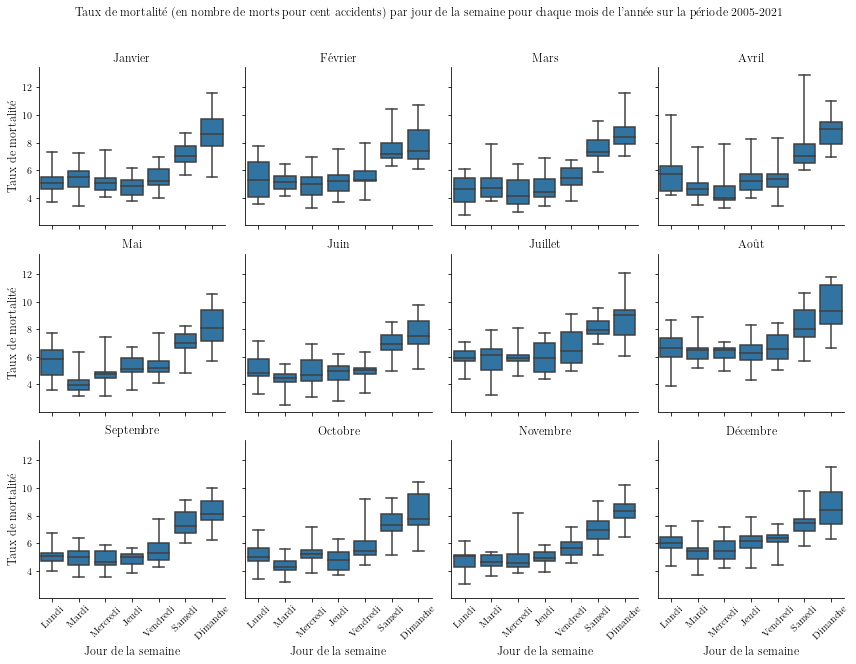

In [167]:
ordre_jours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

g = sns.catplot(x='nom_jour', y='tx_mortalite', data=acc_vs_morts_par_jour, 
                kind='box', order=ordre_jours, whis=[0,100], color='tab:blue',
                col='nom_mois', col_wrap=4,
                height=3, aspect=1)

plt.suptitle("Taux de mortalité (en nombre de morts pour cent accidents) par jour de la semaine pour chaque mois de l'année sur la période 2005-2021", size=12, y=1.02)
g.set_titles('{col_name}',size=12)
g.set_xlabels("Jour de la semaine", size=12)
g.set_xticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], rotation=45)
g.set_ylabels("Taux de mortalité",size=12)
g.fig.subplots_adjust(hspace = 2)
plt.tight_layout()
im = plt.gcf()
im.savefig('img/tx_mort_jour_med.png', dpi=200, bbox_inches="tight")
plt.show()

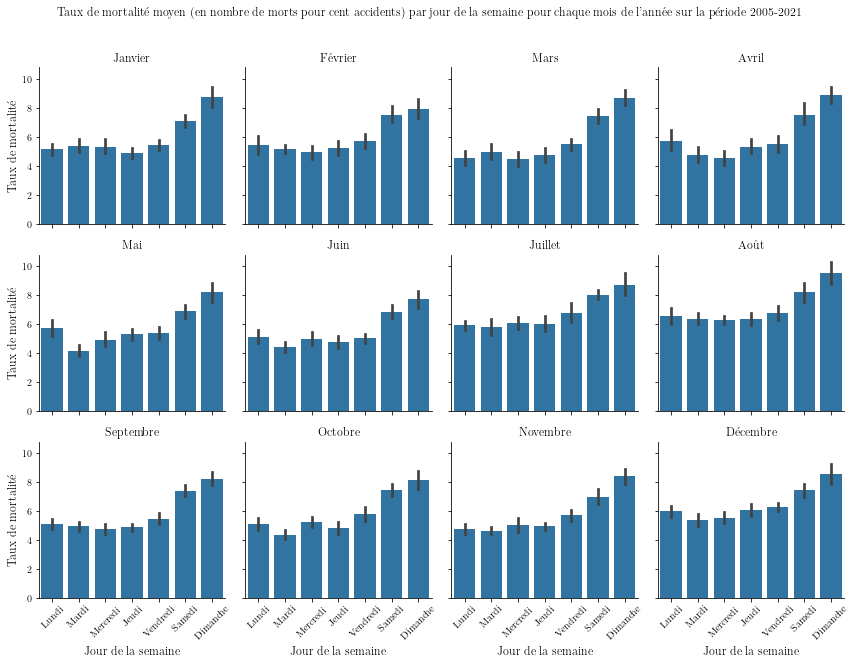

In [168]:
g = sns.catplot(x='nom_jour', y='tx_mortalite', data=acc_vs_morts_par_jour, 
                kind='bar', order=ordre_jours, color='tab:blue',
                col='nom_mois', col_wrap=4,
                height=3, aspect=1)

plt.suptitle("Taux de mortalité moyen (en nombre de morts pour cent accidents) par jour de la semaine pour chaque mois de l'année sur la période 2005-2021", size=12, y=1.02)
g.set_titles('{col_name}',size=12)
g.set_xlabels("Jour de la semaine", size=12)
g.set_xticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], rotation=45)
g.set_ylabels("Taux de mortalité",size=12)
g.fig.subplots_adjust(hspace = 2)
plt.tight_layout()
im = plt.gcf()
im.savefig('img/tx_mort_jour_moy.png', dpi=200, bbox_inches="tight")
plt.show()

Quel que soit le mois, le taux de mortalité augmente le week-end. Quel différence y-a-t-il entre le taux de mortalité moyen le week-end et en semaine pour chaque mois ?

### 2.5.2 Comparaison des taux de mortalités en semaine et le week-end pous chaque mois de l'année.

In [66]:
tx_mort_we = (acc_vs_morts_par_jour
              .loc[acc_vs_morts_par_jour['nom_jour'].isin(['Samedi', 'Dimanche'])]
              .groupby(['mois','nom_mois'])
              .agg(tx_mort_we = pd.NamedAgg('tx_mortalite','mean'))
              .reset_index()
             )
tx_mort_we

,mois,nom_mois,tx_mort_we
0,1,Janvier,7.934478
1,2,Février,7.715609
2,3,Mars,8.057820
3,4,Avril,8.194144
4,5,Mai,7.552664
5,6,Juin,7.292802
6,7,Juillet,8.382621
7,8,Août,8.878838
8,9,Septembre,7.828066
9,10,Octobre,7.787255


In [67]:
tx_mort_sem = (acc_vs_morts_par_jour
              .loc[~acc_vs_morts_par_jour['nom_jour'].isin(['Samedi', 'Dimanche'])]
              .groupby(['mois','nom_mois'])
              .agg(tx_mort_sem = pd.NamedAgg('tx_mortalite','mean'))
              .reset_index()
             )
tx_mort_sem

,mois,nom_mois,tx_mort_sem
0,1,Janvier,5.237393
1,2,Février,5.299147
2,3,Mars,4.849437
3,4,Avril,5.168544
4,5,Mai,5.095289
5,6,Juin,4.864405
6,7,Juillet,6.112726
7,8,Août,6.452162
8,9,Septembre,5.043194
9,10,Octobre,5.069290


In [68]:
comp_tx_mort_we_sem = tx_mort_we.merge(tx_mort_sem, on=['mois','nom_mois'])
comp_tx_mort_we_sem['diff'] = comp_tx_mort_we_sem['tx_mort_we']-comp_tx_mort_we_sem['tx_mort_sem']
comp_tx_mort_we_sem

,mois,nom_mois,tx_mort_we,tx_mort_sem,diff
0,1,Janvier,7.934478,5.237393,2.697085
1,2,Février,7.715609,5.299147,2.416462
2,3,Mars,8.057820,4.849437,3.208383
3,4,Avril,8.194144,5.168544,3.025599
4,5,Mai,7.552664,5.095289,2.457375
5,6,Juin,7.292802,4.864405,2.428398
6,7,Juillet,8.382621,6.112726,2.269895
7,8,Août,8.878838,6.452162,2.426676
8,9,Septembre,7.828066,5.043194,2.784872
9,10,Octobre,7.787255,5.069290,2.717965


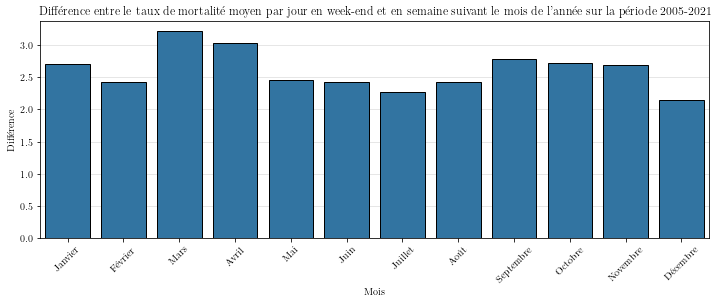

In [169]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='nom_mois', y='diff', data=comp_tx_mort_we_sem, edgecolor='black', color='tab:blue', ax=ax)
plt.title("Différence entre le taux de mortalité moyen par jour en week-end et en semaine suivant le mois de l'année sur la période 2005-2021", size=12)
plt.xlabel('Mois')
plt.ylabel('Différence')
plt.xticks(rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
ax.set_axisbelow(True)
im = plt.gcf()
im.savefig('img/diff_tx_mort_we_sem.png', dpi=200, bbox_inches="tight")
plt.show()

On n'observe pas une différence supérieure en juillet et août concernant du taux de mortalité entre le week-end et la semaine. Le taux de mortalité supérieur de ces deux mois ne s'explique donc pas par les accidents des week-ends de départ en vacance. Le taux est supérieur sur l'ensemble de la semaine.

### 2.5.3 La différence entre le taux de mortalité en semaine et le week-end est-elle significative ?

In [70]:
# Création d'une variable week-end : 1 pour week-end et 0 pour semaine

acc_vs_morts_par_jour['weekend'] = acc_vs_morts_par_jour['nom_jour'].map(lambda x : 1 if x in ['Samedi', 'Dimanche'] else 0)

acc_vs_morts_par_jour.head()

,an,mois,nom_mois,nom_jour,accidents,morts,tx_mortalite,weekend
0,2005,1,Janvier,Dimanche,763,76,9.960682,1
1,2005,1,Janvier,Jeudi,992,41,4.133065,0
2,2005,1,Janvier,Lundi,1127,49,4.347826,0
3,2005,1,Janvier,Mardi,1021,57,5.582762,0
4,2005,1,Janvier,Mercredi,1070,54,5.046729,0


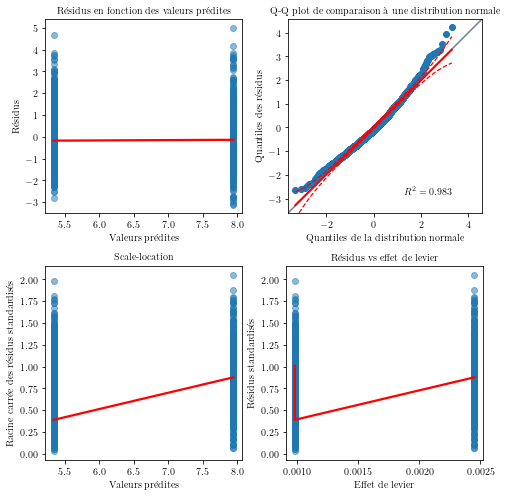

In [71]:
#modèle linéaire du taux de mortalité en fonction de la variable week-end
mod_lin_tx_mort_vs_we = ols('tx_mortalite ~ C(weekend)', data=acc_vs_morts_par_jour).fit()


# Valeurs prédites
fitted_lm = mod_lin_tx_mort_vs_we.fittedvalues
# Résidus
residus_lm = mod_lin_tx_mort_vs_we.resid
#residus standardisés et leur racine carrée
influence_lm = mod_lin_tx_mort_vs_we.get_influence()
residus_norm_lm = influence_lm.resid_studentized_internal
#effet de levier
leverage_lm = influence_lm.hat_matrix_diag

# Graphiques de diagnostic
np.seterr(invalid='ignore')
diagnostic_plots(fitted_lm, residus_lm, residus_norm_lm, leverage_lm)

Les résidus suivent approximativement une loi normale. On ne remarque pas non plus de problème sur le graphique des résidus en fonction des valeurs prédites. Exécutons une ANOVA :

- Hypothèse nulle $\small H_0$ : le taux de mortalité moyen par jour est le même en week-end et en semaine.
- Hypothèse alternative $\small H_1$ : le taux de mortalité moyen par jour est différent en week-end et en semaine.
- Seuil de signification : $\small\alpha=0.05$

In [72]:
anova = sm.stats.anova_lm(mod_lin_tx_mort_vs_we)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(weekend),1.0,1977.608600,1977.608600,1415.082257,1.069340e-215
Residual,1426.0,1992.866386,1.397522,NaN,NaN


On observe une différence très significative entre le taux de mortalité moyen en week-end et en semaine : $\small F(1, 1426)=1415.1, p<0.0001^{***}$. Le taux de mortalité est supérieur le week-end.

## 2.6 Etude suivant l'heure de la journée

Cette partie de l'étude ne portera que sur l'année 2019. En effet, avant 2019, le codage des données de l'heure est ambigü et peut-être interprété de plusieurs manières. Sans information de la part de l'ONISR à ce sujet, il n'est pas possible d'utiliser les données. Concernant les années 2020 et 2021, les différents confinements et couvre-feux viendraient fausser les donner.

### 2.6.1 Nombre d'accidents moyen par heure

L'horaire des accidents est indiqué à la minute près. Nous allons ici recoder la variable de l'heure pour obtenir des classes d'amplitude 1h. Par exemple, tous les accidents ayant eu lieu entre 10h00 et 10h59 feront partie de la tranche horaire 10.

In [73]:
#Sélection de l'année 2019
acc_2019 = df_caract.loc[df_caract['an']==2019]

conditions = [acc_2019['hrmn'].str.startswith('0'+str(i)) if len(str(i))==1 else acc_2019['hrmn'].str.startswith(str(i)) for i in range(24)]
resultats = [i for i in range(24)]

#Recodage des heures
acc_2019['heure'] = np.select(conditions, resultats)

acc_2019.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,date,nom_jour,nom_mois,heure
0,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,1.0,2.0,AUTOROUTE A3,48.8962100,2.4701200,2019-11-30,Samedi,Novembre,1
1,201900000002,30,11,2019,02:50,3.0,93,93066,1,1.0,1.0,6.0,AUTOROUTE A1,48.9307000,2.3688000,2019-11-30,Samedi,Novembre,2
2,201900000003,28,11,2019,15:15,1.0,92,92036,1,1.0,1.0,4.0,AUTOROUTE A86,48.9358718,2.3191744,2019-11-28,Jeudi,Novembre,15
3,201900000004,30,11,2019,20:20,5.0,94,94069,1,1.0,1.0,4.0,A4,48.8173295,2.4281502,2019-11-30,Samedi,Novembre,20
4,201900000005,30,11,2019,04:00,3.0,94,94028,1,1.0,1.0,2.0,A86 INT,48.7763620,2.4332540,2019-11-30,Samedi,Novembre,4


In [74]:
# Calcul du nombre total d'accidents chaque heure de chaque jour de l'année
acc_par_heure = (acc_2019[['Num_Acc','mois', 'jour', 'heure']]
                 .groupby(['mois', 'jour', 'heure'])
                 .agg(nb_acc = pd.NamedAgg('Num_Acc','count'))
                 .reset_index()
                )

# Calcul du nombre moyen, médian, ecart-type d'accidents par heure de la journée
stats_acc_heure = (acc_par_heure
                   .groupby('heure')
                   .agg(moyenne = pd.NamedAgg('nb_acc','mean'),
                        mediane = pd.NamedAgg('nb_acc','median'),
                        std = pd.NamedAgg('nb_acc','std'),)
                   .reset_index()
                  )

stats_acc_heure.transpose()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
heure,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,21.000000,22.000000,23.000000
moyenne,3.419940,2.940984,2.923875,2.319549,2.477273,3.025478,3.722857,7.135734,9.761905,8.388430,...,8.747945,9.484932,11.564384,13.942466,13.268493,10.071233,7.167582,5.223757,4.129213,3.862170
mediane,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,6.000000,9.000000,8.000000,...,8.000000,9.000000,11.000000,14.000000,13.000000,10.000000,7.000000,5.000000,4.000000,3.000000
std,2.095181,1.962592,2.073582,1.622761,1.814458,2.114756,1.906193,4.281857,5.596137,4.046085,...,3.334308,3.601422,4.129011,5.321992,4.972365,3.784057,2.968511,2.434104,2.187066,2.078264


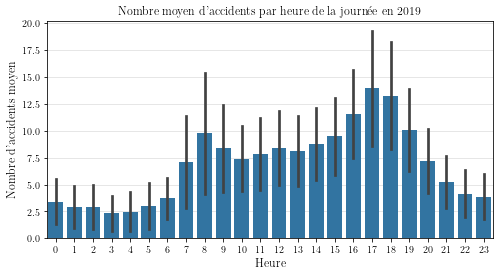

In [171]:
# Représentation graphique du nombre moyen et écart-type
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='heure', y='nb_acc', data= acc_par_heure, color='tab:blue', errorbar='sd')
plt.xlabel('Heure', size=12)
plt.ylabel("Nombre d'accidents moyen", size=12)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Nombre moyen d'accidents par heure de la journée en 2019", size=12)
ax.set_axisbelow(True)
im = plt.gcf()
im.savefig('img/nb_acc_heure.png', dpi=200, bbox_inches="tight")
plt.show()

- Il y a beaucoup plus d'accidents le jour que la nuit.
- On remarque deux pics : entre 8h et 9h et entre 17h et 19h. Hypothèse : ces accidents ont lieux sur les trajets domicile-travail.

Regardons le pourcentage d'accidents domicile-travail en fonction de l'heure de la journée. La variable *trajet* se trouve dans la table *df_usagers*. 

In [76]:
# jointure acc_par_heure avec df_usagers
acc_heure_trajet = (acc_2019
                    .merge(df_usagers[['Num_Acc','trajet']], how='inner', on='Num_Acc')
                    .dropna(subset=['trajet'])
                   )

acc_heure_trajet.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,date,nom_jour,nom_mois,heure,trajet
0,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,1.0,2.0,AUTOROUTE A3,48.8962100,2.4701200,2019-11-30,Samedi,Novembre,1,0.0
1,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,1.0,2.0,AUTOROUTE A3,48.8962100,2.4701200,2019-11-30,Samedi,Novembre,1,5.0
2,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,1.0,2.0,AUTOROUTE A3,48.8962100,2.4701200,2019-11-30,Samedi,Novembre,1,0.0
3,201900000002,30,11,2019,02:50,3.0,93,93066,1,1.0,1.0,6.0,AUTOROUTE A1,48.9307000,2.3688000,2019-11-30,Samedi,Novembre,2,0.0
4,201900000003,28,11,2019,15:15,1.0,92,92036,1,1.0,1.0,4.0,AUTOROUTE A86,48.9358718,2.3191744,2019-11-28,Jeudi,Novembre,15,0.0


In [77]:
# nb de trajets par type de trajet et par heure (codage 1 pour domicile-travail dans la variable trajet)
nb_acc_heure_trajet = (acc_heure_trajet.loc[acc_heure_trajet['trajet']!=0]
                  .groupby(['heure', 'trajet'])
                  .agg(nb_acc = pd.NamedAgg('Num_Acc','count'))
                  .reset_index()
                  .pivot_table(index='heure', columns='trajet', values='nb_acc', fill_value=0)
                 )

nb_acc_heure_trajet.transpose()

heure,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
trajet,,,,,,,,,,,,,,,,,,,,,
1.0,106,87,68,84,166,430,830,2143,2357,1276,...,666,522,888,1526,1580,1059,594,313,194,147
2.0,0,4,0,0,0,7,43,432,637,134,...,71,90,287,348,178,55,11,7,3,2
3.0,4,7,1,0,2,4,15,45,126,284,...,195,260,354,361,384,213,90,43,24,14
4.0,139,109,94,88,114,169,327,659,920,1017,...,862,804,880,829,599,411,377,276,209,171
5.0,1462,1095,991,707,691,869,888,889,1260,1738,...,3084,3609,4064,4716,4655,3673,2706,1995,1632,1636
9.0,160,151,130,75,90,102,186,295,458,464,...,528,589,710,913,810,623,420,307,278,252


In [78]:
# pourcentage de trajets par type de trajet chaque heure (codage 1 pour domicile-travail dans la variable trajet)
pourc_trajet_heure = round(nb_acc_heure_trajet.divide(nb_acc_heure_trajet.sum(axis=1),axis=0)*100, 1)
pourc_trajet_heure.transpose()

heure,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
trajet,,,,,,,,,,,,,,,,,,,,,
1.0,5.7,6.0,5.3,8.8,15.6,27.2,36.3,48.0,40.9,26.0,...,12.3,8.9,12.4,17.6,19.3,17.6,14.1,10.6,8.3,6.6
2.0,0.0,0.3,0.0,0.0,0.0,0.4,1.9,9.7,11.1,2.7,...,1.3,1.5,4.0,4.0,2.2,0.9,0.3,0.2,0.1,0.1
3.0,0.2,0.5,0.1,0.0,0.2,0.3,0.7,1.0,2.2,5.8,...,3.6,4.4,4.9,4.2,4.7,3.5,2.1,1.5,1.0,0.6
4.0,7.4,7.5,7.3,9.2,10.7,10.7,14.3,14.8,16.0,20.7,...,15.9,13.7,12.3,9.5,7.3,6.8,9.0,9.4,8.9,7.7
5.0,78.1,75.4,77.2,74.1,65.0,55.0,38.8,19.9,21.9,35.4,...,57.0,61.4,56.6,54.3,56.7,60.9,64.5,67.8,69.7,73.6
9.0,8.6,10.4,10.1,7.9,8.5,6.5,8.1,6.6,8.0,9.4,...,9.8,10.0,9.9,10.5,9.9,10.3,10.0,10.4,11.9,11.3


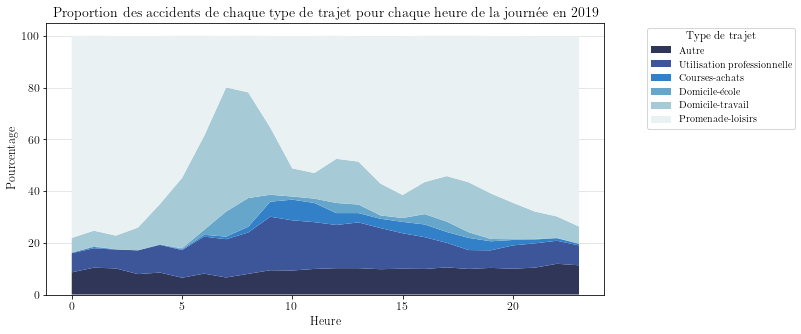

In [172]:
#changement ordre trajets
autre = pourc_trajet_heure[9]
pro = pourc_trajet_heure[4]
courses = pourc_trajet_heure[3]
ecole = pourc_trajet_heure[2]
reste = pourc_trajet_heure.drop(columns=[9,4,3,2])
pourc_trajet_heure = pd.concat([autre, pro, courses, ecole, reste], axis=1)

#choix des couleurs
couleurs = cmr.take_cmap_colors('cmr.arctic', 6, cmap_range=(0.25, 0.95), return_fmt='hex')

#figure
fig,ax = plt.subplots(figsize=(10,5))
plt.stackplot(pourc_trajet_heure.index, pourc_trajet_heure.transpose(), labels=pourc_trajet_heure.columns, colors=couleurs)

#Mise en forme des axes, titre et légende
plt.title('Proportion des accidents de chaque type de trajet pour chaque heure de la journée en 2019', fontsize=14)
plt.xlabel('Heure', fontsize=12)
plt.ylabel('Pourcentage', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, axis='y', color="#e0e0e0")
ax.set_axisbelow(True)
handles, labels = plt.gca().get_legend_handles_labels()  # récupération des handles et labels de la légende
labels = ['Autre', 'Utilisation professionnelle', 'Courses-achats', 'Domicile-école', 'Domicile-travail', 'Promenade-loisirs']   # changement des labels de la légende
plt.legend(handles, labels, title="Type de trajet", bbox_to_anchor=[1.35,1], fontsize=10, title_fontsize=11)
im = plt.gcf()
im.savefig('img/rep_acc_type.png', dpi=200, bbox_inches="tight")
plt.show()

Le pic obtenu entre 8h et 9h correspond bien à une forte proportion des trajets domicile-travail. En revanche, le pic du nombre d'accidents entre 17h et 19h ne semble pas imputable aux trajets domicile-travail. Malgré une augmentation de leur nombre, ce sont bien les déplacements pour loisirs qui prédominent à ce moment de la journée. Il faut cependant nuancer ce constat : dan quelles catégories sont placés les accidents des personnes se rendant faire du sport après le travail ou allant retrouver des amis dans un café ? Il s'agit bien de personnes qui sortent du travail mais qui ne rentrent pas chez elles directement. Elles ont peut-être été comptabilisées dans les loisirs.

### 2.6.2 Taux de mortalité par heure de la journée

Le nombre d'accident lors de chaque heure de l'année étant faible, une différence d'un mort entraîne une grande différence du taux de mortalité. En calculant le taux moyen de mortalité, on risque d'avoir des taux élevés avec de très forts écarts-types. Nous allons plutôt calculer le nombre total d'accidents par heure de la journée et le nombre total de morts correspondants, puis calculer le taux de mortalité par heure sur l'ensemble de l'année.

In [80]:
# Calcul du nombre quotidien de morts

morts_par_heure = (acc_2019[['Num_Acc', 'mois', 'jour', 'heure']]
                   .merge(df_usagers.loc[df_usagers['grav']==2, ['Num_Acc', 'grav']], on='Num_Acc', how='inner')
                   .groupby(['mois','jour','heure'])
                   .agg(nb_morts = pd.NamedAgg('Num_Acc','count'))
                   .reset_index()
                  )

morts_par_heure.head()

,mois,jour,heure,nb_morts
0,1,1,0,2
1,1,1,1,2
2,1,1,2,2
3,1,1,4,1
4,1,1,7,2


In [81]:
# Calcul du nombre quotidien moyen de morts par heure de la journée

stats_morts_heure = (morts_par_heure
                     .groupby('heure')
                     .agg(moyenne = pd.NamedAgg('nb_morts','mean'),
                          mediane = pd.NamedAgg('nb_morts','median'),
                          std = pd.NamedAgg('nb_morts','std'))
                     .reset_index()
                    )

stats_morts_heure.transpose()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
heure,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,21.000000,22.000000,23.000000
moyenne,1.301205,1.303797,1.268657,1.271186,1.188406,1.290698,1.194175,1.191304,1.252336,1.201550,...,1.411765,1.388158,1.488235,1.456250,1.430168,1.423729,1.254098,1.218182,1.271739,1.303371
mediane,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.711147,0.585168,0.664742,0.690590,0.493349,0.683697,0.465648,0.493744,0.533650,0.457231,...,0.741183,0.630876,0.681438,0.716796,0.686454,0.755683,0.538769,0.513699,0.556742,0.610598


In [82]:
tot_acc_heure = (acc_par_heure
                 .groupby('heure')
                 .agg({'nb_acc':'sum'})
                 .reset_index()
                )

tot_morts_heure = (morts_par_heure
                 .groupby('heure')
                 .agg({'nb_morts':'sum'})
                 .reset_index()
                )

tot_morts_acc = tot_acc_heure.merge(tot_morts_heure, on='heure', how='inner')
tot_morts_acc['tx_mortalite'] = round(tot_morts_acc['nb_morts']/tot_morts_acc['nb_acc']*100, 1)
tot_morts_acc.head()

,heure,nb_acc,nb_morts,tx_mortalite
0,0,1132,108,9.5
1,1,897,103,11.5
2,2,845,85,10.1
3,3,617,75,12.2
4,4,654,82,12.5


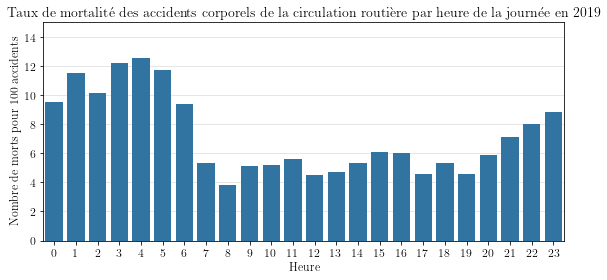

In [173]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='heure', y='tx_mortalite', data=tot_morts_acc, color='tab:blue')
plt.ylim([0,15])
plt.xlabel('Heure', fontsize=12)
plt.ylabel('Nombre de morts pour 100 accidents', fontsize=12)
plt.title('Taux de mortalité des accidents corporels de la circulation routière par heure de la journée en 2019', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, axis='y', color="#e0e0e0")
ax.set_axisbelow(True)
plt.tight_layout()
im = plt.gcf()
im.savefig('img/tx_mort_heure.png', dpi=200, bbox_inches="tight")
plt.show()

En 2019, le taux de mortalité a été plus important la nuit, principalement entre minuit et 7h du matin. Cela correspond aux heures où le nombre d'accidents est le plus faible.

***
# 3. Gravité des accidents et conditions météorologiques et de luminosité

Le but de cette partie est d'étudier si la gravité des blessures des personnes impliquées dans les accidents est indépendante des conditions de circulation en termes de luminosité et de conditions météorologiques.

La plupart des données sur les conditions au moment de l'accidents se trouvent dans la table *df_caract*. Cependant, l'état de la route se trouve dans la table *df_lieux* et la gravité des blessures des personnes impliquées se trouve dans la table *df_usagers*. Nous devons donc procéder à des jointures de tables.

In [84]:
grav_vs_cond = (df_caract[['Num_Acc', 'lum', 'atm']]
                .merge(df_lieux[['Num_Acc', 'surf']], on='Num_Acc', how='inner')
                .merge(df_usagers[['Num_Acc', 'grav']], on='Num_Acc', how='inner')
               )

grav_vs_cond.head()

,Num_Acc,lum,atm,surf,grav
0,201900000001,4.0,1.0,1.0,4.0
1,201900000001,4.0,1.0,1.0,4.0
2,201900000001,4.0,1.0,1.0,1.0
3,201900000002,3.0,1.0,1.0,4.0
4,201900000003,1.0,1.0,1.0,1.0


In [85]:
grav_vs_cond.shape

(2506762, 5)

In [86]:
grav_vs_cond.isna().sum()

Num_Acc        0
lum            6
atm          181
surf       65597
grav          60
dtype: int64

L'étude va porter sur plus de 2,5 millions de personnes. Sur l'ensemble, nous avons très peu de valeurs manquantes, sauf pour l'état de la surface de la route. Mais même pour cette variable, le nombre de valeurs manquantes reste très faible vis à vis du nombre total de lignes de la table.

## 3.1 La gravité est-elle dépendante de la luminosité ?

Pour savoir si la gravité des blessures est associée à la luminosité au moment de l'accident, nous allons procéder à un test du $\small \chi^2$.

Test d'indépendance du chi2 :
- Hypothèse nulle $H_0$ : *grav* et *lum* sont indépendantes.
- Hypothèse alternative $H_1$ : *grav* et *lum* ne sont pas indépendantes.
- Seuil de signification : $\alpha$ = 0.05.

In [87]:
def chi2Mosaicplot(data, x, y, xlabel=None, ylabel=None, title=None, legende_x=None, legende_y=None, nom_fichier=None):
    """Fonction qui
    - réalise le test du chi2 entre deux variables
    - calcule le V de Cramer
    - calcule les résidus de Pearson
    - réalise le mosaicplot des deux variables
    
    data : nom du dataframe pandas
    x : 1ere variable (nom au format str)
    y : 2eme variable (nom au format str)
    xlabel : titre de l'axe des x du mosaicplot
    ylabel : titre de l'axe des y du mosaicplot
    title : titre du mosaicplot
    legende_x : legende des valeurs de x (format str)
    legende_y : legende des valeurs de y (format str)
    nom_fichier : nom du fichier de sauvegarde du mosaicplot au format image
    """
    
    #------------------------------------Importations-----------------------------------------------
    #au cas où elles n'auraient pas été faites auparavant
    import pingouin
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.graphics.mosaicplot as smosaic
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    from IPython.display import display, HTML
    
    #------------------------------------test du chi2-----------------------------------------------
    expected, observed, result = pingouin.chi2_independence(data=data, x=x, y=y)
    display("Tableau de contingence : ",observed, HTML("<br>"))
    display("Valeurs attendues : ",expected, HTML("<br>"))
    display("Résultats du test : ", result.loc[result['test']=='pearson'], HTML("<br>"))
        
    #-------------------------------------V de Cramer-----------------------------------------------
    effectif = observed.sum().sum()
    V = np.sqrt(result.loc[result['test']=='pearson','chi2'].values/(effectif*np.min(observed.shape)))
    display(f"V de Cramer : V = {round(V[0],3)}", HTML("<br>"))
    
    #----------------------------------Résidus de Pearson-------------------------------------------
    residuals = pd.DataFrame((observed - expected) / np.sqrt(expected), index=observed.index, columns=observed.columns)
    display("Résidus de Pearson :", residuals, HTML("<br>"))
    
    #-------------------------------------mosaicplot------------------------------------------------
    #_________________Attribution d'une couleur à chaque valeur de résidu________________________
    # Définir les couleurs
    cmap = mcolors.ListedColormap(['#CB1818', '#EB8D8D', '#BFBFBF', '#86B7FF', '#215DB6'])
    # Définir les limites pour les classes
    bounds = [residuals.min().min(), -4, -2, 2, 4, residuals.max().max()]
    # Créer la norme pour la colormap
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    resid_unstack = residuals.unstack().reset_index()   #unstack pour récupération des paires de valeurs (x,y)
    couleurs_graph = dict()    #dictionnaire associant à chaque couple (x,y) sa couleur en fonction du résidu de Pearson
    for i, row in resid_unstack[[x,y]].iterrows():
        residu = residuals.loc[row[x], row[y]]
        couleurs_graph[str(row[x]), str(row[y])] = cmap(norm(residu)/cmap.N)
    
    #fonction d'attribution des couleurs dans le mosaic plot
    props = lambda key: {'color': couleurs_graph[key]}
    
    #_______________________________Création de la figure___________________________________  

    fig, ax = plt.subplots(figsize=(14,7))
    mosaic = smosaic.mosaic(data.sort_values(by=[x, y]), index=[x, y],
                           properties=props,
                           labelizer=lambda k: '',
                           gap=0.02, ax=ax)
    
    #texte, titre et labels
    if xlabel is not None :
        plt.xlabel(xlabel, size=12)
    if ylabel is not None:
        plt.gca().xaxis.set_label_coords(0.5, -0.1)   #placer xlabel en dessous du graphe
        plt.text(-0.1, 0.5, ylabel, rotation=90, va='center', ha='center', size=12)   #ylabel
    if title is not None :
        plt.title(title, y=1.05, size=12)
    plt.yticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    #pval chi2
    p = result.loc[result['test']=='pearson', 'pval'].values
    if 0.01<=p<0.05:
        text_pvalue = "Test d'indépendance du Chi-2 :\n"+f"p-value={p}"+r"$^{*}$"
    elif 0.001<=p<0.01:
        text_pvalue = "Test d'indépendance du Chi-2 :\n"+f"p-value={p}"+r"$^{**}$"
    elif 0.01<=p<0.001:
        text_pvalue = "Test d'indépendance du Chi-2 :\n"+f"p-value={p}"+r"$^{***}$"
    elif p<0.0001:
        text_pvalue = "Test d'indépendance du Chi-2 :\n"+f"p-value"+r"$<0.0001^{***}$"
    else:
        text_pvalue = "Test d'indépendance du Chi-2 :\n"+f"p-value={p}"
    plt.text(1.2, 0.9, text_pvalue,
             size=11,
             bbox={'boxstyle':'round', 'color':'whitesmoke'})
    
    #legende
    if legende_x is not None and legende_y is not None:
        legende = legende_x + "\n\n" + legende_y
        plt.text(1.2, 0, legende,
                 size=11,
                 bbox={'boxstyle':'round', 'color':'whitesmoke'})
    elif legende_x is not None:
        legende = legende_x
        plt.text(1.2, 0.5, legende,
                 size=11,
                 bbox={'boxstyle':'round', 'color':'whitesmoke'})
    elif legende_y is not None:
        legende = legende_y
        plt.text(1.2, 0.5, legende,
                 size=11,
                 bbox={'boxstyle':'round', 'color':'whitesmoke'})
        
    #Création d'une échelle de couleur pour la légende
    #Créer un objet ScalarMappable à partir de la colormap et de la norm
    scal = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(scal, ticks=[residuals.min().min(),-4,-2,0,2,4,residuals.max().max()], orientation='vertical', ax=ax).set_label(label=f"Résidus de Pearson", size=12)
    
    #Sauvegarde
    if nom_fichier is not None:
        image = plt.gcf()
        image.savefig(nom_fichier, dpi=200, bbox_inches="tight")
    
    #Affichage
    plt.show()

'Tableau de contingence : '

grav,1,2,3,4
lum,,,,
1,732839,37790,329312,623798
2,58738,4797,32470,52372
3,68569,16577,64850,61838
4,7855,714,4165,7836
5,159579,7171,70363,165063


'Valeurs attendues : '

grav,1,2,3,4
lum,,,,
1,706619.279570,46106.498838,344624.572441,626388.649151
2,60824.781968,3968.781804,29664.792747,53918.643481
3,86837.965880,5666.126992,42351.656300,76978.250828
4,8432.343052,550.205502,4112.529481,7474.921965
5,164865.629530,10757.386865,80406.449031,146146.534575


'Résultats du test : '

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,48675.99555,12.0,0.0,0.080454,1.0


'V de Cramer : V = 0.07'

'Résidus de Pearson :'

grav,1,2,3,4
lum,,,,
1,31.191432,-38.731067,-26.084051,-3.273306
2,-8.461294,13.146682,16.287120,-6.660713
3,-61.995354,144.949376,109.323958,-54.569384
4,-6.287237,6.982916,0.818203,4.176358
5,-13.020085,-34.578308,-35.419093,49.481827


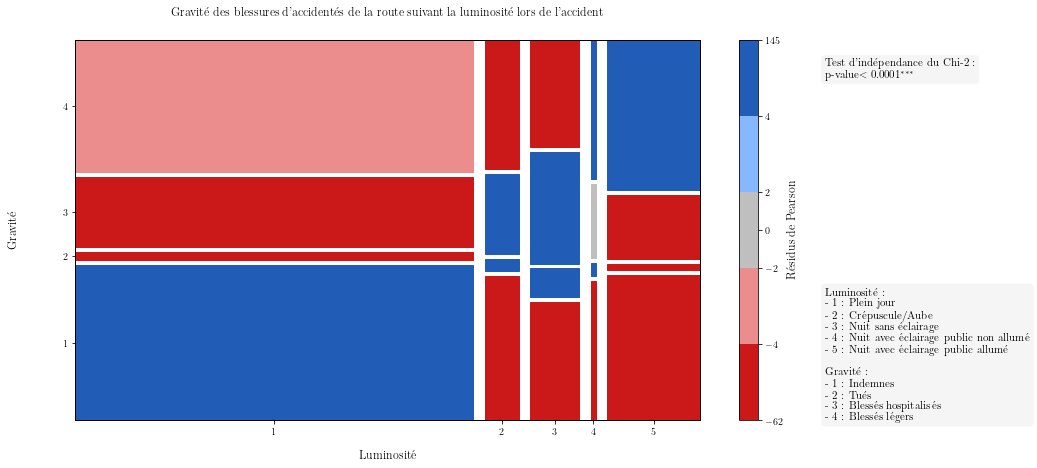

In [88]:
grav_vs_lum = grav_vs_cond[['lum','grav']].dropna()
grav_vs_lum['lum'] = grav_vs_lum['lum'].astype('int')
grav_vs_lum['grav'] = grav_vs_lum['grav'].astype('int')

chi2Mosaicplot(data=grav_vs_lum, x='lum', y='grav',
               xlabel="Luminosité", ylabel="Gravité", title="Gravité des blessures d'accidentés de la route suivant la luminosité lors de l'accident",
               legende_x="Luminosité :\n - 1 : Plein jour\n - 2 : Crépuscule/Aube\n - 3 : Nuit sans éclairage\n - 4 : Nuit avec éclairage public non allumé\n - 5 : Nuit avec éclairage public allumé",
               legende_y="Gravité :\n - 1 : Indemnes\n - 2 : Tués\n - 3 : Blessés hospitalisés\n - 4 : Blessés légers",
               nom_fichier="mosaicplot_lum_grav.png")

- Le test du $\small\chi^2$ révèle une association significative entre la luminosité et la gravité des blessures des personnes impliquées : $\small\chi^2(12) = 48676\,;\,p<0.0001^{***}$

- La force de l'association est faible (V de Cramer proche de 0)

- On remarque une surreprésentation des tués et blessés hospitalisés :
    - La nuit sans éclairage
    - La nuit avec éclairage public éteint
    - A l'aube et au crépuscule <br><br>

- On constate une surreprésentation des personnes indemnes le jour
- On constates une surreprésentation des blessers légers la nuit avec éclairage public (allumé ou éteint)

## 3.2 La gravité est-elle dépendante des conditions météorologiques ?

Test d'indépendance du chi2 :
- Hypothèse nulle $H_0$ : *grav* et *atm* sont indépendantes.
- Hypothèse alternative $H_1$ : *grav* et *atm* ne sont pas indépendantes.
- Seuil de signification : $\alpha$ = 0.05.

'Tableau de contingence : '

grav,1,2,3,4
atm,,,,
1,834124,52052,401595,733001
2,104465,5979,46804,103245
3,21792,1725,11812,19865
4,6516,491,3372,5376
5,6326,1131,5099,4910
6,2090,342,1671,1876
7,12664,1236,8020,7333
8,33609,3220,18113,29726
9,5930,860,4637,5514


'Valeurs attendues : '

grav,1,2,3,4
atm,,,,
1,828389.453889,54044.818213,404008.315492,734329.412405
2,106785.750204,6966.791321,52079.768587,94660.689888
3,22626.069402,1476.143621,11034.809947,20056.977031
4,6458.559326,421.361792,3149.861048,5725.217834
5,7159.961738,467.121870,3491.937358,6346.979034
6,2451.014041,159.906198,1195.367770,2172.711992
7,11991.890572,782.360933,5848.485259,10630.263237
8,34708.556078,2264.415119,16927.479229,30767.549575
9,6944.744750,453.080934,3386.975311,6156.199005


'Résultats du test : '

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,8135.718918,24.0,0.0,0.032893,1.0


'V de Cramer : V = 0.028'

'Résidus de Pearson :'

grav,1,2,3,4
atm,,,,
1,6.300598,-8.572168,-3.796811,-1.550199
2,-7.101854,-11.834470,-23.118051,27.901051
3,-5.544950,6.477158,7.398519,-1.355553
4,0.714746,3.392501,3.958029,-4.615305
5,-9.855775,30.716608,27.195659,-18.037108
6,-7.292076,14.400001,13.756898,-6.365522
7,6.137566,16.218358,28.394948,-31.980232
8,-5.901999,20.081273,9.111986,-5.937908
9,-12.176674,19.117018,21.478927,-8.184899


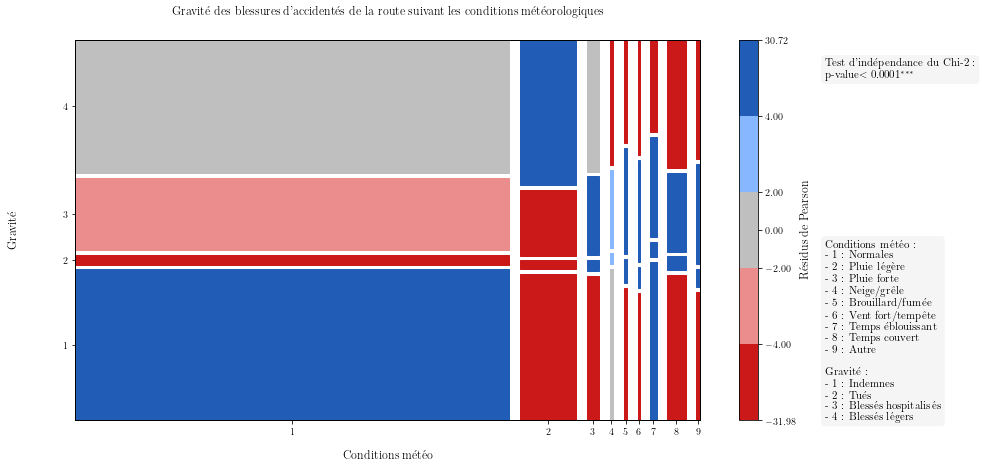

In [89]:
grav_vs_atm = grav_vs_cond[['atm','grav']].dropna()
grav_vs_atm['atm'] = grav_vs_atm['atm'].astype('int')
grav_vs_atm['grav'] = grav_vs_atm['grav'].astype('int')

chi2Mosaicplot(data=grav_vs_atm, x='atm', y='grav',
               xlabel="Conditions météo", ylabel="Gravité", title="Gravité des blessures d'accidentés de la route suivant les conditions météorologiques",
               legende_x="Conditions météo :\n - 1 : Normales\n - 2 : Pluie légère\n - 3 : Pluie forte\n - 4 : Neige/grêle\n - 5 : Brouillard/fumée\n - 6 : Vent fort/tempête\n - 7 : Temps éblouissant\n - 8 : Temps couvert\n - 9 : Autre",
               legende_y="Gravité :\n - 1 : Indemnes\n - 2 : Tués\n - 3 : Blessés hospitalisés\n - 4 : Blessés légers",
               nom_fichier="mosaicplot_atm_grav.png")

- Le test du $\small\chi^2$ révèle une association significative entre les conditions météo et la gravité des blessures des personnes impliquées : $\small\chi^2(24) = 8136\,;\,p<0.0001^{***}$

- La force de l'association est faible (V de Cramer proche de 0)

- On remarque une surreprésentation des tués et blessés hospitalisés dans toutes les conditions sauf pour des conditions normales ou de pluie légère.
- On constate une surreprésentation des personnes indemnes dans des conditions normales
- On constate une surreprésentation des blessers légers lors de pluies légères. Dans ce cas, les personnes indemnes sont sous-représentées.

## 3.2 La gravité est-elle dépendante de l'état de la route ?

Test d'indépendance du chi2 :
- Hypothèse nulle $H_0$ : *grav* et *surf* sont indépendantes.
- Hypothèse alternative $H_1$ : *grav* et *surf* ne sont pas indépendantes.
- Seuil de signification : $\alpha$ = 0.05.

'Tableau de contingence : '

grav,1,2,3,4
surf,,,,
1,816662,51426,392165,705418
2,170149,12479,83494,165340
3,1044,127,842,1133
4,450,73,309,409
5,3315,253,1734,2710
6,306,67,422,346
7,4626,671,4249,4822
8,1270,125,1134,2323
9,3290,674,3727,3521


'Valeurs attendues : '

grav,1,2,3,4
surf,,,,
1,806133.626432,53061.171291,393017.440461,713458.761816
2,176945.189062,11646.851934,86266.771447,156603.187558
3,1290.193725,84.922881,629.013130,1141.870264
4,508.941644,33.499458,248.126285,450.432612
5,3285.769905,216.275310,1601.924093,2908.030693
6,467.931036,30.800066,228.132225,414.136673
7,5892.404143,387.848683,2872.746550,5215.000623
8,1989.834695,130.974514,970.111794,1761.078997
9,4598.109358,302.655863,2241.734015,4069.500765


'Résultats du test : '

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,5216.226066,24.0,0.0,0.026689,1.0


'V de Cramer : V = 0.023'

'Résidus de Pearson :'

grav,1,2,3,4
surf,,,,
1,11.726213,-7.098635,-1.359747,-9.519470
2,-16.156455,7.710745,-9.440441,22.077643
3,-6.854085,4.565976,8.492254,-0.262499
4,-2.612692,6.824709,3.864501,-1.952214
5,0.509931,2.497208,3.299914,-3.672257
6,-7.485816,6.522768,12.835486,-3.348182
7,-16.497801,14.377634,25.677324,-5.442094
8,-16.137055,-0.522046,5.261830,13.390162
9,-19.290985,21.345288,31.369832,-8.598183


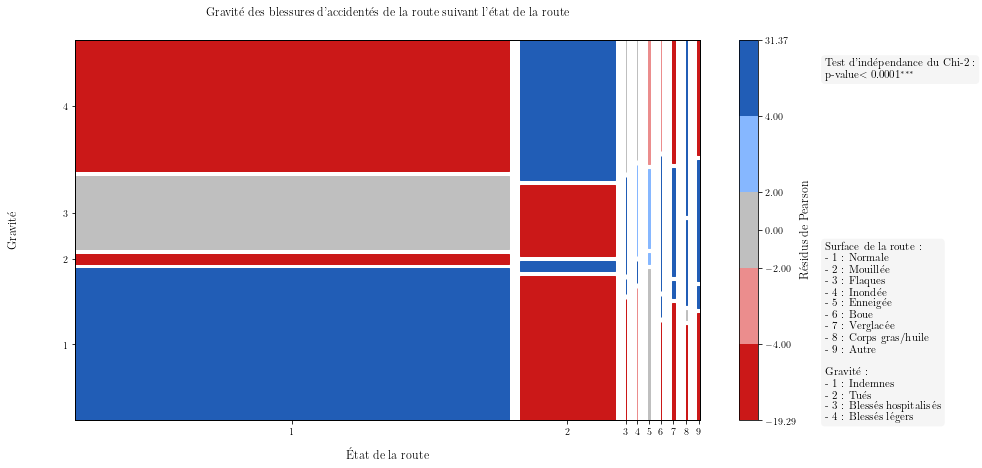

In [90]:
grav_vs_surf = grav_vs_cond[['surf','grav']].dropna()
grav_vs_surf['surf'] = grav_vs_surf['surf'].astype('int')
grav_vs_surf['grav'] = grav_vs_surf['grav'].astype('int')

chi2Mosaicplot(data=grav_vs_surf, x='surf', y='grav',
               xlabel="État de la route", ylabel="Gravité", title="Gravité des blessures d'accidentés de la route suivant l'état de la route",
               legende_x="Surface de la route :\n - 1 : Normale\n - 2 : Mouillée\n - 3 : Flaques\n - 4 : Inondée\n - 5 : Enneigée\n - 6 : Boue\n - 7 : Verglacée\n - 8 : Corps gras/huile\n - 9 : Autre",
               legende_y="Gravité :\n - 1 : Indemnes\n - 2 : Tués\n - 3 : Blessés hospitalisés\n - 4 : Blessés légers",
               nom_fichier="mosaicplot_surf_grav.png")

- Le test du $\small\chi^2$ révèle une association significative entre l'état de la route et la gravité des blessures des personnes impliquées : $\small\chi^2(24) = 5216\,;\,p<0.0001^{***}$

- La force de l'association est faible (V de Cramer proche de 0)

- On remarque une surreprésentation des tués et blessés hospitalisés dans toutes les conditions sauf pour des conditions normales ou de route mouillée.
- On constate une surreprésentation des personnes indemnes dans des conditions normales
- On constate une surreprésentation des blessers légers pour des accidents de routes mouillées ou grasses.

***
# 4. Mortalité sur la route

Concentrons nous sur la mortalité sur la route en fonction des conditions météo et de luminosité à l'aide d'une régression logistique. Il peut y avoir plusieurs personnes impliquées dans un accident. L'accident ne doit apparaître qu'une seule fois. 

In [91]:
# numéros d'accidents mortels
num_acc_mort = (df_usagers
                .loc[df_usagers['grav']==2, ['Num_Acc']]
                .drop_duplicates()
               )

# Ajout colonne binaire avec uniquement des 1
num_acc_mort['mort'] = 1
num_acc_mort.head()

,Num_Acc,mort
16,200500000006,1
35,200500000016,1
50,200500000022,1
57,200500000025,1
70,200500000029,1


In [92]:
# jointure avec grav_vs_cond (left-join pour conserver tous les accidents)
mort_vs_cond = (grav_vs_cond
                .drop_duplicates()
                .merge(num_acc_mort, on='Num_Acc', how='left')
               )

# les accidents non mortels ont une valeur manquante dans la variable 'mort'
mort_vs_cond.loc[mort_vs_cond['mort'].isna(),'mort']=0
mort_vs_cond.sample(n=5)

,Num_Acc,lum,atm,surf,grav,mort
1616375,201600034876,1.0,2.0,2.0,4.0,0.0
171128,202000038140,3.0,2.0,2.0,4.0,0.0
882834,201000000075,1.0,1.0,1.0,1.0,0.0
1670150,201700005578,1.0,1.0,1.0,4.0,0.0
564818,200600066069,1.0,1.0,1.0,3.0,0.0


## 4.1 Modèle de régression logistique ne tenant compte que de la luminosité

In [93]:
#modèle de régression logistique
log_model_lum = glm("mort ~ C(lum)", data= mort_vs_cond, family = sm.families.Binomial()).fit()
log_model_lum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:              2004033
Model:                            GLM   Df Residuals:                  2004028
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.2817e+05
Date:                Mon, 10 Jul 2023   Deviance:                   8.5633e+05
Time:                        08:27:14   Pearson chi2:                 2.00e+06
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01603
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.9756      0.004   -755.078      0.000      -2.983      -2.968
C(lum)[T.2.0]     0.3720      0.012     30.774      0.000       0.348       0.396
C(lum)[T.3.0]     1.4483      0.008    186.543      0.000       1.433       1.463
C(lum)[T.4.0]     0.4915      0.030     16.438      0.000       0.433       0.550
C(lum)[T.5.0]    -0.2656      0.010    -26.395      0.000      -0.285      -0.246
=================================================================================
"""

In [94]:
# Odds rations
df_log_mod_lum = pd.DataFrame(np.exp(log_model_lum.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_lum = np.exp(log_model_lum.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_lum = pd.DataFrame(log_model_lum.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_lum = pd.concat([df_log_mod_lum, ci_log_mod_lum, pval_log_mod_lum], axis=1).reset_index().rename(columns={'index':'Luminosité'})
# remplacement des valeurs de l'Intercept
df_log_mod_lum.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# remplacement des valeurs de luminosité
df_log_mod_lum['Luminosité'] = df_log_mod_lum['Luminosité'].replace(['C(lum)[T.2.0]', 'C(lum)[T.3.0]', 'C(lum)[T.4.0]', 'C(lum)[T.5.0]'],
                                                                    ['Aube/Crép', 'Nuit sans écl.', 'Nuit avec écl. éteint', 'Nuit avec écl. allum.'])
df_log_mod_lum

,Luminosité,OR,0.025,0.975,pval
0,Normale (référence),1.000000,1.000000,1.000000,NaN
1,Aube/Crép,1.450576,1.416616,1.485350,5.836209e-208
2,Nuit sans écl.,4.255713,4.191446,4.320966,0.000000e+00
3,Nuit avec écl. éteint,1.634826,1.541764,1.733505,1.029337e-60
4,Nuit avec écl. allum.,0.766708,0.751732,0.781982,1.576575e-153


In [95]:
#Arrondis des p-values
df_log_mod_lum['pval_rec'] = df_log_mod_lum['pval'].map(lambda x : round(x,4) if round(x,4)!=0 else r'$<$0.0001')

#Ajout des *
for i in range(df_log_mod_lum.shape[0]):
    if df_log_mod_lum.iloc[i,4]<0.001:
        df_log_mod_lum.iloc[i,5]=str(df_log_mod_lum.iloc[i,5])+'***'
    elif df_log_mod_lum.iloc[i,4]<0.01:
        df_log_mod_lum.iloc[i,5]=str(df_log_mod_lum.iloc[i,5])+'**'
    elif df_log_mod_lum.iloc[i,4]<0.05:
        df_log_mod_lum.iloc[i,5]=str(df_log_mod_lum.iloc[i,5])+'*'
    elif np.isnan(df_log_mod_lum.iloc[i,4]):
        df_log_mod_lum.iloc[i,5]='-'
        
#Arrondis des OR et CI
df_log_mod_lum[['OR','0.025','0.975']]=round(df_log_mod_lum[['OR','0.025','0.975']],2)
df_log_mod_lum

,Luminosité,OR,0.025,0.975,pval,pval_rec
0,Normale (référence),1.00,1.00,1.00,NaN,-
1,Aube/Crép,1.45,1.42,1.49,5.836209e-208,$<$0.0001***
2,Nuit sans écl.,4.26,4.19,4.32,0.000000e+00,$<$0.0001***
3,Nuit avec écl. éteint,1.63,1.54,1.73,1.029337e-60,$<$0.0001***
4,Nuit avec écl. allum.,0.77,0.75,0.78,1.576575e-153,$<$0.0001***


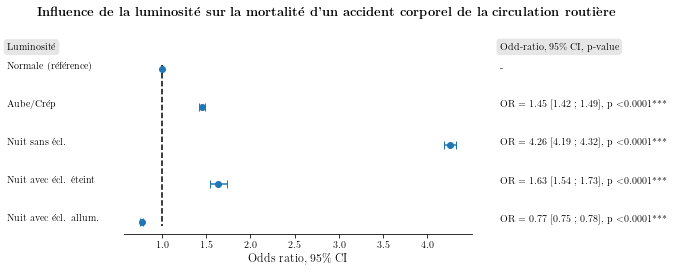

In [96]:
#forest plot
fig, ax= plt.subplots(figsize=(11,4))
plt.errorbar(x=df_log_mod_lum['OR'], y=-df_log_mod_lum.index, 
             xerr=(df_log_mod_lum['OR']-df_log_mod_lum['0.025'], df_log_mod_lum['0.975']-df_log_mod_lum['OR']), 
             fmt='o', capsize=4)
plt.vlines(x=1, ymin=-df_log_mod_lum.index.min()+0.1, ymax=-df_log_mod_lum.index.max()-0.1, linestyle='dashed', color='black')
ax.yaxis.set_visible(False)
ax.spines[['left', 'top', 'right']].set_visible(False)

#abscisses d'affichage des modalités et p-values
x_modalites = df_log_mod_lum['0.025'].min()-1.5
x_OR = df_log_mod_lum['0.975'].max()+0.5

#Affichage du text
for i in range(len(df_log_mod_lum)):
    plt.text(x_modalites, -i, df_log_mod_lum.iloc[i,0])
    
    if df_log_mod_lum.iloc[i,5]=="-":
        plt.text(x_OR, -i, "-")
    else:
        plt.text(x_OR, -i, f"OR = {df_log_mod_lum.iloc[i,1]} [{df_log_mod_lum.iloc[i,2]} ; {df_log_mod_lum.iloc[i,3]}], p {df_log_mod_lum.iloc[i,5]}")
        
#titre et labels
plt.text(x_modalites, 0.5, "Luminosité", fontsize=10, bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))
plt.text(x_OR, 0.5, "Odd-ratio, 95\% CI, p-value", fontsize=10, bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))        
plt.title(r"\textbf{Influence de la luminosité sur la mortalité d'un accident corporel de la circulation routière}",
          fontsize=13, x=0.58 , y=1.2)
plt.xlabel('Odds ratio, 95\% CI', fontsize=12)
plt.tight_layout()
image = plt.gcf()
image.savefig('forest_plot_lum.png', dpi=200, bbox_inches="tight")
plt.show()

On remarque que la luminosité a bien une influence sur la mortalité d'un accident corporel de la circulation routière :
- dans toutes les conditions de faible luminosité sans éclairage public, on a plus de chances qu'un accident soit mortel qu'en plein jour. C'est le cas en particulier la nuit sans éclairage $(\scriptsize O.R. = 4.26, C.I.=[4.19\,;\,4.32])$ 
- on a moins de chances qu'un accident soit mortel la nuit dans un lieu éclairé qu'en plein jour $(\scriptsize O.R. = 0.77, C.I.=[0.75\,;\,0.78])$. Il serait intéressant de mener une étude pour comprendre pourquoi. Voici une hypothèse : les éclairages sont surtout placés en agglomération où la vitesse est réduite, alors que la catégorie regroupant les accidents ayant eu lieu en plein jour comptabilise à la fois ceux ayant eu lieu à forte vitesse et ceux ayant eu lieu à vitesse réduite. Il serait intéressant de faire la même étude mais en distinguant les accidents en agglomération et hors-agglomération par exemple.

## 4.2 Modèle de régression logistique ne tenant compte que des conditions météorologiques

In [97]:
#modèle de régression logistique
log_model_atm = glm("mort ~ C(atm)", data= mort_vs_cond, family = sm.families.Binomial()).fit()
log_model_atm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:              2003886
Model:                            GLM   Df Residuals:                  2003877
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.4224e+05
Date:                Mon, 10 Jul 2023   Deviance:                   8.8448e+05
Time:                        08:27:31   Pearson chi2:                 2.00e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.002056
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.8323      0.003   -826.715      0.000      -2.839      -2.826
C(atm)[T.2.0]    -0.0989      0.011     -9.322      0.000      -0.120      -0.078
C(atm)[T.3.0]     0.2617      0.019     13.675      0.000       0.224       0.299
C(atm)[T.4.0]     0.3886      0.035     11.099      0.000       0.320       0.457
C(atm)[T.5.0]     1.1220      0.025     44.978      0.000       1.073       1.171
C(atm)[T.6.0]     0.7912      0.046     17.217      0.000       0.701       0.881
C(atm)[T.7.0]     0.6034      0.022     27.429      0.000       0.560       0.646
C(atm)[T.8.0]     0.4366      0.014     30.283      0.000       0.408       0.465
C(atm)[T.9.0]     0.7637      0.028     27.214      0.000       0.709       0.819
=================================================================================
"""

In [98]:
# Odds rations
df_log_mod_atm = pd.DataFrame(np.exp(log_model_atm.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_atm = np.exp(log_model_atm.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_atm = pd.DataFrame(log_model_atm.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_atm = pd.concat([df_log_mod_atm, ci_log_mod_atm, pval_log_mod_atm], axis=1).reset_index().rename(columns={'index':'Conditions météo'})
# remplacement des valeurs de l'Intercept
df_log_mod_atm.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# remplacement des valeurs de météo
df_log_mod_atm['Conditions météo'] = df_log_mod_atm['Conditions météo'].replace(['C(atm)[T.2.0]', 'C(atm)[T.3.0]', 'C(atm)[T.4.0]', 'C(atm)[T.5.0]',
                                                                                 'C(atm)[T.6.0]', 'C(atm)[T.7.0]', 'C(atm)[T.8.0]', 'C(atm)[T.9.0]'],
                                                                                ['Pluie légère', 'Pluie forte', 'Neige/grêle', 'Brouillard/fumée',
                                                                                 'Vent fort/tempête', 'Temps éblouissant', 'Temps couvert', 'Autre'])
df_log_mod_atm

,Conditions météo,OR,0.025,0.975,pval
0,Normale (référence),1.000000,1.000000,1.000000,NaN
1,Pluie légère,0.905864,0.887228,0.924892,1.144637e-20
2,Pluie forte,1.299109,1.251287,1.348759,1.441486e-42
3,Neige/grêle,1.474956,1.377126,1.579735,1.272330e-28
4,Brouillard/fumée,3.071009,2.924470,3.224891,0.000000e+00
5,Vent fort/tempête,2.206065,2.016048,2.413991,1.983282e-66
6,Temps éblouissant,1.828256,1.751108,1.908803,1.236616e-165
7,Temps couvert,1.547512,1.504390,1.591870,1.938996e-201
8,Autre,2.146124,2.031274,2.267468,4.484966e-163


In [99]:
#Arrondis des p-values
df_log_mod_atm['pval_rec'] = df_log_mod_atm['pval'].map(lambda x : round(x,4) if round(x,4)!=0 else r'$<$0.0001')

#Ajout des *
for i in range(df_log_mod_atm.shape[0]):
    if df_log_mod_atm.iloc[i,4]<0.001:
        df_log_mod_atm.iloc[i,5]=str(df_log_mod_atm.iloc[i,5])+'***'
    elif df_log_mod_atm.iloc[i,4]<0.01:
        df_log_mod_atm.iloc[i,5]=str(df_log_mod_atm.iloc[i,5])+'**'
    elif df_log_mod_atm.iloc[i,4]<0.05:
        df_log_mod_atm.iloc[i,5]=str(df_log_mod_atm.iloc[i,5])+'*'
    elif np.isnan(df_log_mod_atm.iloc[i,4]):
        df_log_mod_atm.iloc[i,5]='-'
        
#Arrondis des OR et CI
df_log_mod_atm[['OR','0.025','0.975']]=round(df_log_mod_atm[['OR','0.025','0.975']],2)
df_log_mod_atm

,Conditions météo,OR,0.025,0.975,pval,pval_rec
0,Normale (référence),1.00,1.00,1.00,NaN,-
1,Pluie légère,0.91,0.89,0.92,1.144637e-20,$<$0.0001***
2,Pluie forte,1.30,1.25,1.35,1.441486e-42,$<$0.0001***
3,Neige/grêle,1.47,1.38,1.58,1.272330e-28,$<$0.0001***
4,Brouillard/fumée,3.07,2.92,3.22,0.000000e+00,$<$0.0001***
5,Vent fort/tempête,2.21,2.02,2.41,1.983282e-66,$<$0.0001***
6,Temps éblouissant,1.83,1.75,1.91,1.236616e-165,$<$0.0001***
7,Temps couvert,1.55,1.50,1.59,1.938996e-201,$<$0.0001***
8,Autre,2.15,2.03,2.27,4.484966e-163,$<$0.0001***


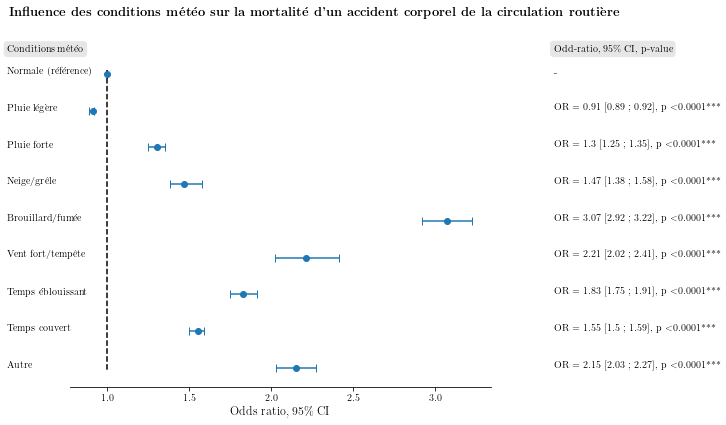

In [100]:
#forest plot
fig, ax= plt.subplots(figsize=(11,6))
plt.errorbar(x=df_log_mod_atm['OR'], y=-df_log_mod_atm.index, 
             xerr=(df_log_mod_atm['OR']-df_log_mod_atm['0.025'], df_log_mod_atm['0.975']-df_log_mod_atm['OR']), 
             fmt='o', capsize=4)
plt.vlines(x=1, ymin=-df_log_mod_atm.index.min()+0.1, ymax=-df_log_mod_atm.index.max()-0.1, linestyle='dashed', color='black')
ax.yaxis.set_visible(False)
ax.spines[['left', 'top', 'right']].set_visible(False)

#abscisses d'affichage des modalités et p-values
x_modalites = df_log_mod_atm['0.025'].min()-0.5
x_OR = df_log_mod_atm['0.975'].max()+0.5

#Affichage du text
for i in range(len(df_log_mod_atm)):
    plt.text(x_modalites, -i, df_log_mod_atm.iloc[i,0])
    
    if df_log_mod_atm.iloc[i,5]=="-":
        plt.text(x_OR, -i, "-")
    else:
        plt.text(x_OR, -i, f"OR = {df_log_mod_atm.iloc[i,1]} [{df_log_mod_atm.iloc[i,2]} ; {df_log_mod_atm.iloc[i,3]}], p {df_log_mod_atm.iloc[i,5]}")
        
#titre et labels
plt.text(x_modalites, 0.6, "Conditions météo", fontsize=10, bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))
plt.text(x_OR, 0.6, "Odd-ratio, 95\% CI, p-value", fontsize=10, bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))        
plt.title(r"\textbf{Influence des conditions météo sur la mortalité d'un accident corporel de la circulation routière}",
          fontsize=13, x=0.58 , y=1.1)
plt.xlabel('Odds ratio, 95\% CI', fontsize=12)
plt.tight_layout()
image = plt.gcf()
image.savefig('forest_plot_atm.png', dpi=200, bbox_inches="tight")
plt.show()

Nous observons un effet significatif de toutes les conditions météo :
- À part les conditions de pluie légères, toutes les autres augmentent les chances de mortalité lors des accidents corporels par rapport à des conditions de temps sec. En particulier, le brouillard et les conditions de vent fort augmentent particulièrement les chances qu'un accident corporel soit mortel.
- De manière surprenante, une pluie légère baisse les chances qu'un accident corporel soit mortel.

## 4.3 Modèle de régression logistique ne tenant compte que de l'état de la route

In [101]:
#modèle de régression logistique
log_model_surf = glm("mort ~ C(surf)", data= mort_vs_cond, family = sm.families.Binomial()).fit()
log_model_surf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:              1949604
Model:                            GLM   Df Residuals:                  1949595
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.3497e+05
Date:                Mon, 10 Jul 2023   Deviance:                   8.6995e+05
Time:                        08:27:48   Pearson chi2:                 1.95e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0006290
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.8123      0.003   -816.801      0.000      -2.819      -2.806
C(surf)[T.2.0]     0.1367      0.008     17.508      0.000       0.121       0.152
C(surf)[T.3.0]     0.3489      0.075      4.673      0.000       0.203       0.495
C(surf)[T.4.0]     0.7948      0.103      7.684      0.000       0.592       0.998
C(surf)[T.5.0]     0.3947      0.048      8.143      0.000       0.300       0.490
C(surf)[T.6.0]     0.5844      0.109      5.352      0.000       0.370       0.798
C(surf)[T.7.0]     0.7085      0.031     22.603      0.000       0.647       0.770
C(surf)[T.8.0]     0.0795      0.068      1.164      0.244      -0.054       0.213
C(surf)[T.9.0]     0.7544      0.033     22.656      0.000       0.689       0.820
==================================================================================
"""

In [102]:
# Odds rations
df_log_mod_surf = pd.DataFrame(np.exp(log_model_surf.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_surf = np.exp(log_model_surf.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_surf = pd.DataFrame(log_model_surf.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_surf = pd.concat([df_log_mod_surf, ci_log_mod_surf, pval_log_mod_surf], axis=1).reset_index().rename(columns={'index':'Surface de la route'})
# remplacement des valeurs de l'Intercept
df_log_mod_surf.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# remplacement des valeurs de surf
df_log_mod_surf['Surface de la route'] = df_log_mod_surf['Surface de la route'].replace(['C(surf)[T.2.0]', 'C(surf)[T.3.0]', 'C(surf)[T.4.0]', 'C(surf)[T.5.0]',
                                                                                        'C(surf)[T.6.0]', 'C(surf)[T.7.0]', 'C(surf)[T.8.0]', 'C(surf)[T.9.0]'],
                                                                                       ['Mouillée', 'Flaques', 'Inondée', 'Enneigée',
                                                                                        'Boue', 'Verglacée', 'Corps gras/huile', 'Autre'])
df_log_mod_surf

,Surface de la route,OR,0.025,0.975,pval
0,Normale (référence),1.000000,1.000000,1.000000,NaN
1,Mouillée,1.146453,1.129046,1.164128,1.239729e-68
2,Flaques,1.417568,1.224555,1.641004,2.973292e-06
3,Inondée,2.214075,1.807762,2.711711,1.544753e-14
4,Enneigée,1.483867,1.349397,1.631738,3.866176e-16
5,Boue,1.793977,1.448341,2.222096,8.685693e-08
6,Verglacée,2.030848,1.909843,2.159521,4.081430e-113
7,Corps gras/huile,1.082715,0.947089,1.237763,2.444861e-01
8,Autre,2.126424,1.992072,2.269837,1.214782e-113


In [103]:
#Arrondis des p-values
df_log_mod_surf['pval_rec'] = df_log_mod_surf['pval'].map(lambda x : '= '+str(round(x,4)) if round(x,4)!=0 else r'$<$0.0001')

#Ajout des *
for i in range(df_log_mod_surf.shape[0]):
    if df_log_mod_surf.iloc[i,4]<0.001:
        df_log_mod_surf.iloc[i,5]=str(df_log_mod_surf.iloc[i,5])+'***'
    elif df_log_mod_surf.iloc[i,4]<0.01:
        df_log_mod_surf.iloc[i,5]=str(df_log_mod_surf.iloc[i,5])+'**'
    elif df_log_mod_surf.iloc[i,4]<0.05:
        df_log_mod_surf.iloc[i,5]=str(df_log_mod_surf.iloc[i,5])+'*'
    elif np.isnan(df_log_mod_surf.iloc[i,4]):
        df_log_mod_surf.iloc[i,5]='-'
        
#Arrondis des OR et CI
df_log_mod_surf[['OR','0.025','0.975']]=round(df_log_mod_surf[['OR','0.025','0.975']],2)
df_log_mod_surf

,Surface de la route,OR,0.025,0.975,pval,pval_rec
0,Normale (référence),1.00,1.00,1.00,NaN,-
1,Mouillée,1.15,1.13,1.16,1.239729e-68,$<$0.0001***
2,Flaques,1.42,1.22,1.64,2.973292e-06,$<$0.0001***
3,Inondée,2.21,1.81,2.71,1.544753e-14,$<$0.0001***
4,Enneigée,1.48,1.35,1.63,3.866176e-16,$<$0.0001***
5,Boue,1.79,1.45,2.22,8.685693e-08,$<$0.0001***
6,Verglacée,2.03,1.91,2.16,4.081430e-113,$<$0.0001***
7,Corps gras/huile,1.08,0.95,1.24,2.444861e-01,= 0.2445
8,Autre,2.13,1.99,2.27,1.214782e-113,$<$0.0001***


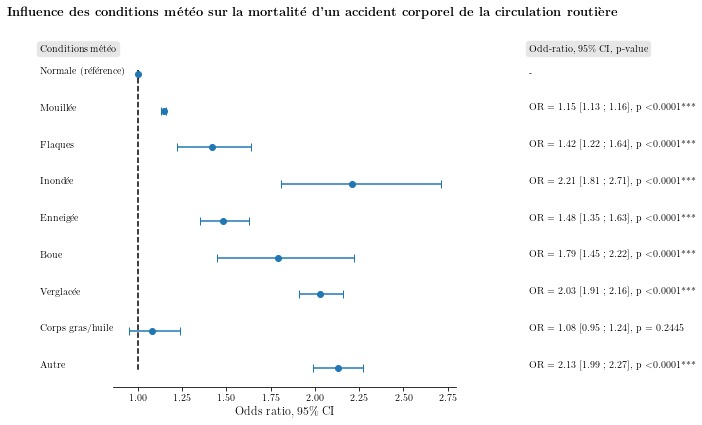

In [104]:
#forest plot
fig, ax= plt.subplots(figsize=(11,6))
plt.errorbar(x=df_log_mod_surf['OR'], y=-df_log_mod_surf.index, 
             xerr=(df_log_mod_surf['OR']-df_log_mod_surf['0.025'], df_log_mod_surf['0.975']-df_log_mod_surf['OR']), 
             fmt='o', capsize=4)
plt.vlines(x=1, ymin=-df_log_mod_surf.index.min()+0.1, ymax=-df_log_mod_surf.index.max()-0.1, linestyle='dashed', color='black')
ax.yaxis.set_visible(False)
ax.spines[['left', 'top', 'right']].set_visible(False)

#abscisses d'affichage des modalités et p-values
x_modalites = df_log_mod_surf['0.025'].min()-0.5
x_OR = df_log_mod_surf['0.975'].max()+0.5

#Affichage du text
for i in range(len(df_log_mod_surf)):
    plt.text(x_modalites, -i, df_log_mod_surf.iloc[i,0])
    
    if df_log_mod_surf.iloc[i,5]=="-":
        plt.text(x_OR, -i, "-")
    else:
        plt.text(x_OR, -i, f"OR = {df_log_mod_surf.iloc[i,1]} [{df_log_mod_surf.iloc[i,2]} ; {df_log_mod_surf.iloc[i,3]}], p {df_log_mod_surf.iloc[i,5]}")
        
#titre et labels
plt.text(x_modalites, 0.6, "Conditions météo", fontsize=10, bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))
plt.text(x_OR, 0.6, "Odd-ratio, 95\% CI, p-value", fontsize=10, bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))        
plt.title(r"\textbf{Influence des conditions météo sur la mortalité d'un accident corporel de la circulation routière}",
          fontsize=13, x=0.58 , y=1.1)
plt.xlabel('Odds ratio, 95\% CI', fontsize=12)
plt.tight_layout()
image = plt.gcf()
image.savefig('forest_plot_surf.png', dpi=200, bbox_inches="tight")
plt.show()

Par rapport à une route sèche en bon état :
- On ne peut pas rejeter l'hypothèse que la présence d'un corps gras n'a pas d'influence sur la mortalité.
- Toutes les autres conditions ont un effet significatif sur la mortalité en augmentant les chances qu'un accident soit mortel. On remarque notamment que l'effet d'une situation de route verglacée est plus important que les situations de route mouillée ou enneigée.
- Concernant les situations de routes inondées ou boueuses, les intervalles de confiance sont très amples. Le fait d'obtenir un effet très important est donc à prendre avec précaution.
- Les "autres" conditions ont un effet important mais nous ne savons pas ce que recouvre cette dénomination.

## 4.4 Modèle de régression logistique de la gravité tenant compte des trois variables

In [105]:
#modèle de régression logistique
log_model_ens = glm("mort ~ C(lum) + C(atm) + C(surf)", data= mort_vs_cond, family = sm.families.Binomial()).fit()
log_model_ens.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:              1949512
Model:                            GLM   Df Residuals:                  1949491
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.1814e+05
Date:                Mon, 10 Jul 2023   Deviance:                   8.3628e+05
Time:                        08:28:31   Pearson chi2:                 1.95e+06
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01772
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.9971      0.004   -706.194      0.000      -3.005      -2.989
C(lum)[T.2.0]      0.3628      0.012     29.547      0.000       0.339       0.387
C(lum)[T.3.0]      1.4296      0.008    177.730      0.000       1.414       1.445
C(lum)[T.4.0]      0.5118      0.030     16.962      0.000       0.453       0.571
C(lum)[T.5.0]     -0.2447      0.010    -23.900      0.000      -0.265      -0.225
C(atm)[T.2.0]     -0.3136      0.016    -20.205      0.000      -0.344      -0.283
C(atm)[T.3.0]     -0.0100      0.023     -0.441      0.659      -0.055       0.035
C(atm)[T.4.0]      0.0518      0.048      1.079      0.281      -0.042       0.146
C(atm)[T.5.0]      0.5496      0.027     20.438      0.000       0.497       0.602
C(atm)[T.6.0]      0.5464      0.048     11.433      0.000       0.453       0.640
C(atm)[T.7.0]      0.7380      0.022     33.127      0.000       0.694       0.782
C(atm)[T.8.0]      0.2960      0.016     18.529      0.000       0.265       0.327
C(atm)[T.9.0]      0.3925      0.033     11.900      0.000       0.328       0.457
C(surf)[T.2.0]     0.1293      0.013     10.284      0.000       0.105       0.154
C(surf)[T.3.0]     0.2082      0.077      2.702      0.007       0.057       0.359
C(surf)[T.4.0]     0.5547      0.108      5.146      0.000       0.343       0.766
C(surf)[T.5.0]     0.1116      0.064      1.731      0.083      -0.015       0.238
C(surf)[T.6.0]     0.2136      0.112      1.903      0.057      -0.006       0.434
C(surf)[T.7.0]     0.0950      0.037      2.561      0.010       0.022       0.168
C(surf)[T.8.0]     0.1139      0.069      1.648      0.099      -0.022       0.249
C(surf)[T.9.0]     0.5733      0.034     16.684      0.000       0.506       0.641
==================================================================================
"""

In [106]:
# Odds rations
df_log_mod_ens = pd.DataFrame(np.exp(log_model_ens.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_ens = np.exp(log_model_ens.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_ens = pd.DataFrame(log_model_ens.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_ens = pd.concat([df_log_mod_ens, ci_log_mod_ens, pval_log_mod_ens], axis=1).reset_index().rename(columns={'index':'modalite'})
# remplacement des valeurs de l'Intercept
df_log_mod_ens.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# Ajout de la référence pour la météo et l'état de la route
meteo_ref = pd.DataFrame([{'modalite':'Normale (référence)', 'OR':1, '0.025':1, '0.975':1, 'pval':np.nan}])    #référence météo = normale
surf_ref = pd.DataFrame([{'modalite':'Normale (référence)', 'OR':1, '0.025':1, '0.975':1, 'pval':np.nan}])    #référence surf = normale
nv_index=[0,1,2,3,4,21,5,6,7,8,9,10,11,12,22,13,14,15,16,17,18,19,20]
df_log_mod_ens = pd.concat([df_log_mod_ens, meteo_ref, surf_ref]).reset_index(drop=True).reindex(nv_index).reset_index(drop=True)    #ajout référence hdi



# remplacement des valeurs 
df_log_mod_ens['modalite'] = df_log_mod_ens['modalite'].replace(['C(lum)[T.2.0]', 'C(lum)[T.3.0]', 'C(lum)[T.4.0]', 'C(lum)[T.5.0]',
                                                                                       'C(atm)[T.2.0]', 'C(atm)[T.3.0]', 'C(atm)[T.4.0]', 'C(atm)[T.5.0]',
                                                                                       'C(atm)[T.6.0]', 'C(atm)[T.7.0]', 'C(atm)[T.8.0]', 'C(atm)[T.9.0]',
                                                                                       'C(surf)[T.2.0]', 'C(surf)[T.3.0]', 'C(surf)[T.4.0]', 'C(surf)[T.5.0]',
                                                                                       'C(surf)[T.6.0]', 'C(surf)[T.7.0]', 'C(surf)[T.8.0]', 'C(surf)[T.9.0]'],
                                                                                      ['Aube/Crép', 'Nuit sans écl.', 'Nuit avec écl. éteint', 'Nuit avec écl. allum.',
                                                                                       'Pluie légère', 'Pluie forte', 'Neige/grêle', 'Brouillard/fumée',
                                                                                       'Vent fort/tempête', 'Temps éblouissant', 'Temps couvert', 'Autre',
                                                                                       'Mouillée', 'Flaques', 'Inondée', 'Enneigée',
                                                                                       'Boue', 'Verglacée', 'Corps gras/huile', 'Autre'])

#création de la variable avec les noms des variables
liste_var = ['luminosité' for i in range(5)]
liste_var.extend(['météo' for i in range(9)])
liste_var.extend(['État route' for i in range(9)])
var = pd.DataFrame({'variable': liste_var})

df_log_mod_ens = pd.concat([var, df_log_mod_ens], axis=1)
df_log_mod_ens

,variable,modalite,OR,0.025,0.975,pval
0,luminosité,Normale (référence),1.000000,1.000000,1.000000,NaN
1,luminosité,Aube/Crép,1.437392,1.403210,1.472406,7.124440e-192
2,luminosité,Nuit sans écl.,4.177221,4.111880,4.243600,0.000000e+00
3,luminosité,Nuit avec écl. éteint,1.668275,1.572479,1.769907,1.563441e-64
4,luminosité,Nuit avec écl. allum.,0.782919,0.767363,0.798790,3.065157e-126
5,météo,Normale (référence),1.000000,1.000000,1.000000,NaN
6,météo,Pluie légère,0.730827,0.708931,0.753399,8.824446e-91
7,météo,Pluie forte,0.990003,0.946791,1.035188,6.590502e-01
8,météo,Neige/grêle,1.053195,0.958576,1.157153,2.805387e-01
9,météo,Brouillard/fumée,1.732543,1.643593,1.826306,7.710431e-93


In [107]:
#Arrondis des p-values
df_log_mod_ens['pval_rec'] = df_log_mod_ens['pval'].map(lambda x : '= '+str(round(x,4)) if round(x,4)!=0 else r'$<$0.0001')

#Ajout des *
for i in range(df_log_mod_ens.shape[0]):
    if df_log_mod_ens.iloc[i,5]<0.001:
        df_log_mod_ens.iloc[i,6]=str(df_log_mod_ens.iloc[i,6])+'***'
    elif df_log_mod_ens.iloc[i,5]<0.01:
        df_log_mod_ens.iloc[i,6]=str(df_log_mod_ens.iloc[i,6])+'**'
    elif df_log_mod_ens.iloc[i,5]<0.05:
        df_log_mod_ens.iloc[i,6]=str(df_log_mod_ens.iloc[i,6])+'*'
    elif np.isnan(df_log_mod_ens.iloc[i,5]):
        df_log_mod_ens.iloc[i,6]='-'
        
#Arrondis des OR et CI
df_log_mod_ens[['OR','0.025','0.975']]=round(df_log_mod_ens[['OR','0.025','0.975']],2)
df_log_mod_ens

,variable,modalite,OR,0.025,0.975,pval,pval_rec
0,luminosité,Normale (référence),1.00,1.00,1.00,NaN,-
1,luminosité,Aube/Crép,1.44,1.40,1.47,7.124440e-192,$<$0.0001***
2,luminosité,Nuit sans écl.,4.18,4.11,4.24,0.000000e+00,$<$0.0001***
3,luminosité,Nuit avec écl. éteint,1.67,1.57,1.77,1.563441e-64,$<$0.0001***
4,luminosité,Nuit avec écl. allum.,0.78,0.77,0.80,3.065157e-126,$<$0.0001***
5,météo,Normale (référence),1.00,1.00,1.00,NaN,-
6,météo,Pluie légère,0.73,0.71,0.75,8.824446e-91,$<$0.0001***
7,météo,Pluie forte,0.99,0.95,1.04,6.590502e-01,= 0.6591
8,météo,Neige/grêle,1.05,0.96,1.16,2.805387e-01,= 0.2805
9,météo,Brouillard/fumée,1.73,1.64,1.83,7.710431e-93,$<$0.0001***


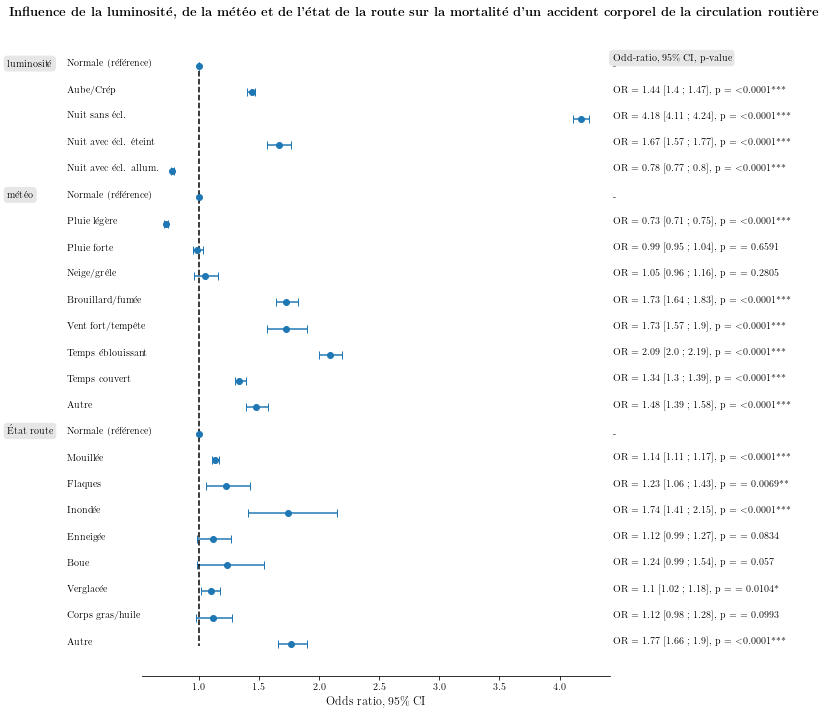

In [108]:
#forest plot
fig, ax= plt.subplots(figsize=(12,10))
plt.errorbar(x=df_log_mod_ens['OR'], y=-df_log_mod_ens.index, xerr=(df_log_mod_ens['OR']-df_log_mod_ens['0.025'], df_log_mod_ens['0.975']-df_log_mod_ens['OR']), fmt='o', capsize=4)
plt.vlines(x=1, ymin=-df_log_mod_ens.index.min()+0.1, ymax=-df_log_mod_ens.index.max()-0.1, linestyle='dashed', color='black')
ax.yaxis.set_visible(False)
ax.spines[['left', 'top', 'right']].set_visible(False)

#abscisses d'affichage des modalités, variables et p-values
x_var = df_log_mod_ens['0.025'].min()-1.3
x_modalites = df_log_mod_ens['0.025'].min()-0.8
x_OR = df_log_mod_ens['0.975'].max()+0.2

#Affichage du text
var_affichee = 0    #1 si la variable de la ligne a déjà été affichée, 0 sinon (évite d'afficher la variable à chaque ligne)
var = df_log_mod_ens.iloc[0,0]
for i in range(len(df_log_mod_ens)):
    plt.text(x_modalites, -i, df_log_mod_ens.iloc[i,1])
    
    if df_log_mod_ens.iloc[i,6]=="-":
        plt.text(x_OR, -i, "-")
    else:
        plt.text(x_OR, -i, f"OR = {df_log_mod_ens.iloc[i,2]} [{df_log_mod_ens.iloc[i,3]} ; {df_log_mod_ens.iloc[i,4]}], p = {df_log_mod_ens.iloc[i,6]}")
        
    if var != df_log_mod_ens.iloc[i,0]:
        var = df_log_mod_ens.iloc[i,0]
        var_affichee=0
        
    if var_affichee==0:
        plt.text(x_var, -i, df_log_mod_ens.iloc[i,0], bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))
        var_affichee=1

#titre et labels         
plt.text(x_OR, 0.2, "Odd-ratio, 95\% CI, p-value", fontsize=10, bbox=dict(boxstyle="round", color=(0.9,0.9,0.9)))        
plt.title(r"\textbf{Influence de la luminosité, de la météo et de l'état de la route sur la mortalité d'un accident corporel de la circulation routière}",
          fontsize=13, x=0.58 , y=1.02)
plt.xlabel('Odds ratio, 95\% CI', fontsize=12)
plt.tight_layout()
image = plt.gcf()
image.savefig('forest_plot_ens.png', dpi=200, bbox_inches="tight", transparent=True)
plt.show()

- On remarque que le facteur le plus influent sur la mortalité d'un accident est la luminosité : l'odds-ratio le plus important est celui correspondant aux accidents de nuit sans éclairage. On remarque encore une fois un odds-ratio inférieur à 1 concernant les accidents de nuit avec éclairage allumé.
- Concernant la météo, on remarque encore une fois que les accidents ayant eu lieu lors d'une pluie légère ont moins de chance d'être mortels. La pluie forte et la grêle ou la neige n'ont pas d'effet significatif. En revanche, les autres conditions augmentent le risque de mortalité d'un accident.
- Enfin, concernant l'état de la route, l'humidité augmente le risque qu'un accident soit mortel. En revanche, pas d'effet significatif pour ou la présence de corps gras. Concernant la neige ou le verglas, cela vient en contradiction avec le modèle n'utilisant que l'état de la route comme variable explicative. On peut donc penser que leur effet est absorbé dans le modèle par les facteurs météo et/ou de luminosité. Regardons si on peut trouver une association entre nos variables explicatives.

Pour cette étude, pour éviter d'avoir des effectifs de modalités trop petits (par exemple, il n'y a que 2 accidents par temps éblouissant et route inondée), Faisons des regroupements :

- regroupements dans la variable *atm* :
    - pluie légère et pluie forte
    - vent fort, temps éblouissant et autre
- regroupements de *surf* :
    - mouillée, flaques et inondées
    - boue, corps gras et autre

In [109]:
mort_vs_cond['atm_rec'] = mort_vs_cond['atm'].replace([3,6,7], [2,9,9])
mort_vs_cond['surf_rec'] = mort_vs_cond['surf'].replace([3,4,6,8],
                                                        [2,2,9,9])

surf_vs_lum = mort_vs_cond[['lum','surf_rec']].dropna().astype('int')
atm_vs_surf = mort_vs_cond[['atm_rec','surf_rec']].dropna().astype('int')
atm_vs_lum = mort_vs_cond[['lum','atm_rec']].dropna().astype('int')

'Tableau de contingence : '

surf_rec,1,2,5,7,9
lum,,,,,
1,1154710,184058,3305,4547,9780
2,83079,29304,554,1663,972
3,101747,42119,985,2762,1559
4,10955,4356,29,112,111
5,227622,81546,821,1548,1360


'Valeurs attendues : '

surf_rec,1,2,5,7,9
lum,,,,,
1,1.097942e+06,237510.746387,3961.492488,7397.012316,9588.565062
2,9.355011e+04,20237.092290,337.538786,630.262096,816.993248
3,1.207477e+05,26120.578782,435.670715,813.496846,1054.515945
4,1.259752e+04,2725.139889,45.453190,84.871500,110.016837
5,2.532754e+05,54789.442651,913.844821,1706.357242,2211.908908


'Résultats du test : '

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,58882.133064,16.0,0.0,0.086894,1.0


'V de Cramer : V = 0.078'

'Résidus de Pearson :'

surf_rec,1,2,5,7,9
lum,,,,,
1,54.176688,-109.680240,-10.430385,-33.137410,1.954989
2,-34.235030,63.736049,11.781979,41.136707,5.423022
3,-54.680309,98.988725,26.318042,68.316117,15.535344
4,-14.634160,31.240812,-2.440439,2.944726,0.093734
5,-50.974054,114.309360,-3.071294,-3.833566,-18.113799


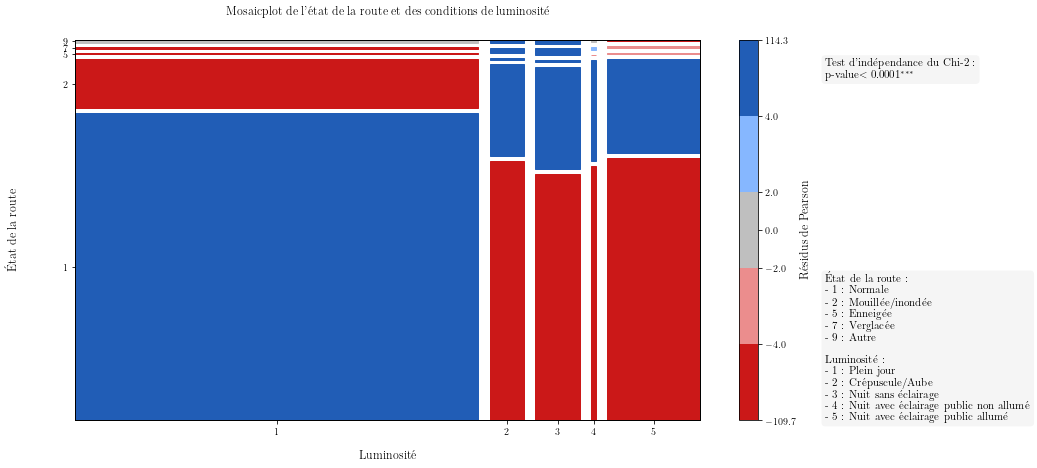

In [110]:
chi2Mosaicplot(data=surf_vs_lum, x='lum', y='surf_rec',
               xlabel="Luminosité", ylabel="État de la route", title="Mosaicplot de l'état de la route et des conditions de luminosité",
               legende_x="État de la route :\n - 1 : Normale\n - 2 : Mouillée/inondée\n - 5 : Enneigée\n - 7 : Verglacée\n - 9 : Autre",
               legende_y="Luminosité :\n - 1 : Plein jour\n - 2 : Crépuscule/Aube\n - 3 : Nuit sans éclairage\n - 4 : Nuit avec éclairage public non allumé\n - 5 : Nuit avec éclairage public allumé",
               nom_fichier="mosaicplot_surf_lum.png")

'Tableau de contingence : '

surf_rec,1,2,5,7,9
atm_rec,,,,,
1,1497263,64228,453,2501,10165
2,13419,230934,50,532,1311
4,284,3511,4905,2155,212
5,6102,5209,13,692,280
8,32143,31186,155,879,950
9,28823,6304,118,3873,862


'Valeurs attendues : '

surf_rec,1,2,5,7,9
atm_rec,,,,,
1,1.274569e+06,275724.265827,4599.012132,8587.407269,11130.029361
2,1.993240e+05,43119.247028,719.218309,1342.945041,1740.573990
4,8.958192e+03,1937.902369,32.323729,60.355794,78.226377
5,9.953007e+03,2153.108117,35.913308,67.058357,86.913484
8,5.286766e+04,11436.723363,190.761699,356.195713,461.660734
9,3.236184e+04,7000.753296,116.770823,218.037827,282.596055


'Résultats du test : '

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,2.137610e+06,20.0,0.0,0.523566,1.0


'V de Cramer : V = 0.468'

'Résidus de Pearson :'

surf_rec,1,2,5,7,9
atm_rec,,,,,
1,197.254189,-402.777507,-61.136179,-65.679521,-9.147288
2,-416.400549,904.469902,-24.953843,-22.129026,-10.296550
4,-91.647124,35.734666,857.051321,269.619179,15.124948
5,-38.600873,65.857473,-3.823491,76.315545,20.711348
8,-90.134768,184.671716,-2.589241,27.700959,22.727945
9,-19.671821,-8.327347,0.113749,247.523800,34.466597


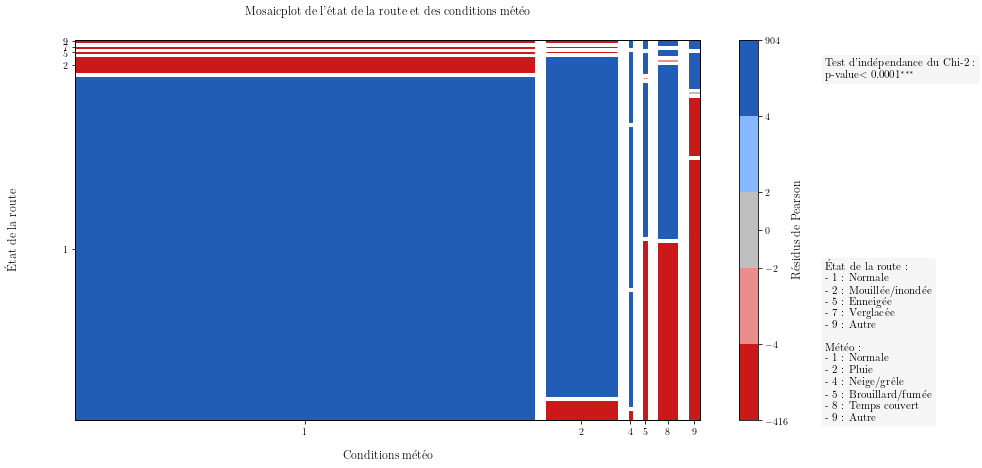

In [111]:
chi2Mosaicplot(data=atm_vs_surf, x='atm_rec', y='surf_rec',
               xlabel="Conditions météo", ylabel="État de la route", title="Mosaicplot de l'état de la route et des conditions météo",
               legende_x="État de la route :\n - 1 : Normale\n - 2 : Mouillée/inondée\n - 5 : Enneigée\n - 7 : Verglacée\n - 9 : Autre",
               legende_y="Météo :\n - 1 : Normale\n - 2 : Pluie\n - 4 : Neige/grêle\n - 5 : Brouillard/fumée\n - 8 : Temps couvert\n - 9 : Autre",
               nom_fichier="mosaicplot_atm_surf.png")

L'état de la route possède une association significative avec les conditions météos et la luminosité. Cela peut expliquer que dans notre modèle les effets relatifs aux routes enneigées et verglacées soient absorbés par les effets de conditions météorologiques et de luminosité. On remarque notamment que la force de l'association entre les conditions météo et l'état de la route est assez importante (V de Cramer = 0.5)

- Les accidents sur routes enneigées ou verglacées sont surreprésentées lors des nuits sur routes non éclairées et à l'aube ou au crépuscule. Ils sont sous-représentés en plein jour ou la nuit dans des lieux éclairés.
- Les accidents sur routes enneigées sont surreprésentés quand il neige et sous-représentés dans les autres conditions.
- Les accidents sur routes verglacées sont sous-représentés quand il fait beau et par temps de pluie, mais surreprésentés dans les autres conditions.

Regardons s'il y a association entre les variables de luminosité et de conditions météo.

'Tableau de contingence : '

lum,1,2,3,4,5
atm_rec,,,,,
1,1176012,85039,108348,11788,241279
2,133408,21346,28026,3250,63190
4,6208,1112,1864,95,1922
5,3876,2583,4095,174,1902
8,43998,5947,6395,521,9745
9,30668,3341,3757,186,3811


'Valeurs attendues : '

lum,1,2,3,4,5
atm_rec,,,,,
1,1.128803e+06,96647.474701,123460.979322,12965.892533,260588.206931
2,1.733906e+05,14845.601476,18964.308199,1991.634794,40027.829817
4,7.792907e+03,667.224068,852.336153,89.512484,1799.019829
5,8.787110e+03,752.347110,961.075405,100.932299,2028.534992
8,4.634000e+04,3967.603450,5068.360131,532.280022,10697.751516
9,2.905591e+04,2487.749195,3177.940789,333.747869,6707.656916


'Résultats du test : '

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,60000.063941,20.0,0.0,0.086519,1.0


'V de Cramer : V = 0.077'

'Résidus de Pearson :'

lum,1,2,3,4,5
atm_rec,,,,,
1,44.433603,-37.340481,-43.011563,-10.344380,-37.825707
2,-96.019293,53.350818,65.802256,28.196931,115.770584
4,-17.953708,17.218901,34.652197,0.580008,2.899460
5,-52.390995,66.741640,101.090376,7.272946,-2.809438
8,-10.879521,31.424522,18.634567,-0.488922,-9.211564
9,9.457435,17.106982,10.271883,-8.087457,-35.368093


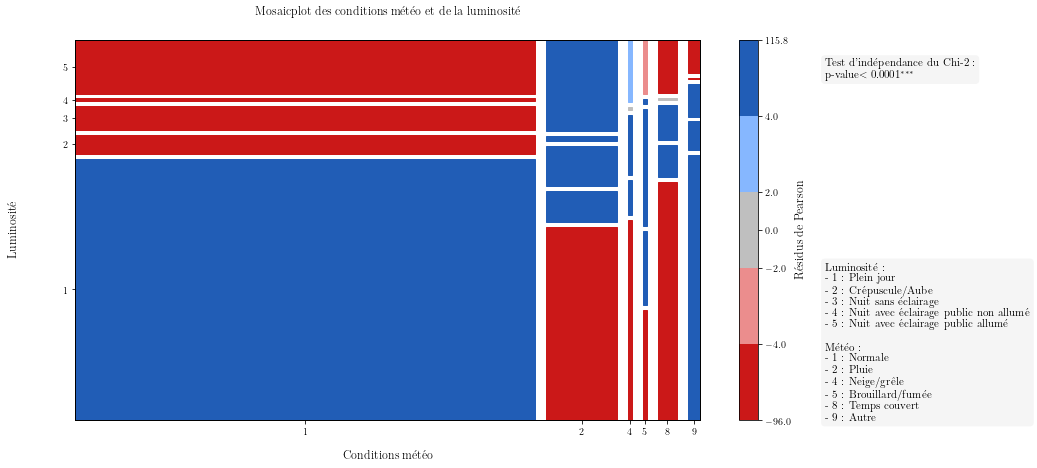

In [112]:
chi2Mosaicplot(data=atm_vs_lum, x='atm_rec', y='lum',
               xlabel="Conditions météo", ylabel="Luminosité", title="Mosaicplot des conditions météo et de la luminosité",
               legende_x="Luminosité :\n - 1 : Plein jour\n - 2 : Crépuscule/Aube\n - 3 : Nuit sans éclairage\n - 4 : Nuit avec éclairage public non allumé\n - 5 : Nuit avec éclairage public allumé",
               legende_y="Météo :\n - 1 : Normale\n - 2 : Pluie\n - 4 : Neige/grêle\n - 5 : Brouillard/fumée\n - 8 : Temps couvert\n - 9 : Autre",
               nom_fichier="mosaicplot_atm_lum.png")

Là-aussi, on trouve une associtation significative entre les deux variables ($\scriptsize p<0.0001^{***}$).
Les accidents ayant lieu dans des conditions météo dégradées sont en proportion plus importante dans des conditions de faible luminosité plutôt qu'en plein jour.

In [113]:
# Calcul du VIF des trois variables *lum*, *atm* et *surf*.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Création des matrices de design à partir de la formule de votre modèle
y, X = dmatrices('mort ~ C(lum) + C(atm) + C(surf)', data=mort_vs_cond, return_type='dataframe')

# Calcul du VIF pour chaque variable prédictive
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.634920,Intercept
1,1.031637,C(lum)[T.2.0]
2,1.048637,C(lum)[T.3.0]
3,1.004882,C(lum)[T.4.0]
4,1.052731,C(lum)[T.5.0]
5,2.488117,C(atm)[T.2.0]
6,1.371641,C(atm)[T.3.0]
7,1.789257,C(atm)[T.4.0]
8,1.034690,C(atm)[T.5.0]
9,1.004161,C(atm)[T.6.0]


## 4.5 Retour sur l'influence de l'enneigement et du verglas en distingant plusieurs modèles

Nous avond vu précédemment que l'influence d'une route verglacée ou enneigée varie fortement entre le modèle ne tenant compte que de l'état de la route et le modèle tenant compte des trois variables. Étant donné que l'état de la route est associé aux conditions météo et de luminosité, essayons de déterminer l'influence de l'état de la route sur la mortalité des accidents suivant les cas suivants :
- plein jour et conditions météo normales
- plein jour et conditions de météo neigeuse
- faible luminosité (nuit ou aube/crépuscule) et conditions météo normales
- faible luminosité et conditions de météo neigeuse

### 4.5.1 Conditions météo et de luminosité normales 

In [114]:
mort_vs_cond_norm = mort_vs_cond.loc[(mort_vs_cond['lum']==1) & (mort_vs_cond['atm']==1)]

#modèle de régression logistique
log_model_surf = glm("mort ~ C(surf)", data= mort_vs_cond_norm, family = sm.families.Binomial()).fit()
log_model_surf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:              1141910
Model:                            GLM   Df Residuals:                  1141901
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1713e+05
Date:                Mon, 10 Jul 2023   Deviance:                   4.3427e+05
Time:                        08:30:10   Pearson chi2:                 1.14e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0002114
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0145      0.005   -666.380      0.000      -3.023      -3.006
C(surf)[T.2.0]     0.1325      0.024      5.543      0.000       0.086       0.179
C(surf)[T.3.0]     0.4235      0.175      2.416      0.016       0.080       0.767
C(surf)[T.4.0]     0.7809      0.351      2.226      0.026       0.093       1.468
C(surf)[T.5.0]     0.3032      0.225      1.345      0.179      -0.139       0.745
C(surf)[T.6.0]     0.5577      0.190      2.931      0.003       0.185       0.931
C(surf)[T.7.0]     0.4068      0.109      3.722      0.000       0.193       0.621
C(surf)[T.8.0]    -0.1614      0.116     -1.387      0.166      -0.390       0.067
C(surf)[T.9.0]     0.7135      0.048     14.823      0.000       0.619       0.808
==================================================================================
"""

In [115]:
# Odds rations
df_log_mod_surf = pd.DataFrame(np.exp(log_model_surf.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_surf = np.exp(log_model_surf.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_surf = pd.DataFrame(log_model_surf.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_surf = pd.concat([df_log_mod_surf, ci_log_mod_surf, pval_log_mod_surf], axis=1).reset_index().rename(columns={'index':'Surface de la route'})
# remplacement des valeurs de l'Intercept
df_log_mod_surf.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# remplacement des valeurs de surf
df_log_mod_surf['Surface de la route'] = df_log_mod_surf['Surface de la route'].replace(['C(surf)[T.2.0]', 'C(surf)[T.3.0]', 'C(surf)[T.4.0]', 'C(surf)[T.5.0]',
                                                                                        'C(surf)[T.6.0]', 'C(surf)[T.7.0]', 'C(surf)[T.8.0]', 'C(surf)[T.9.0]'],
                                                                                       ['Mouillée', 'Flaques', 'Inondée', 'Enneigée',
                                                                                        'Boue', 'Verglacée', 'Corps gras/huile', 'Autre'])
df_log_mod_surf

,Surface de la route,OR,0.025,0.975,pval
0,Normale (référence),1.000000,1.000000,1.000000,NaN
1,Mouillée,1.141680,1.089428,1.196439,2.967287e-08
2,Flaques,1.527269,1.083159,2.153469,1.570817e-02
3,Inondée,2.183371,1.097881,4.342097,2.600155e-02
4,Enneigée,1.354243,0.870638,2.106470,1.785070e-01
5,Boue,1.746697,1.202931,2.536262,3.379799e-03
6,Verglacée,1.502073,1.212380,1.860987,1.979226e-04
7,Corps gras/huile,0.850930,0.677347,1.068998,1.655118e-01
8,Autre,2.041222,1.857441,2.243186,1.040491e-49


- Pas d'effet significatif d'une route enneigée
- Un effet significatif du verglas, mais moindre par rapport au modèle ayant la surface de la route comme seul prédicteur mais en tenant compte de toutes les conditions de luminosité et de météo

### 4.5.2 Conditions météo neigeuses et plein jour.

In [116]:
mort_vs_cond_neige = mort_vs_cond.loc[(mort_vs_cond['lum']==1) & (mort_vs_cond['atm']==4)]

#modèle de régression logistique
log_model_surf = glm("mort ~ C(surf)", data= mort_vs_cond_neige, family = sm.families.Binomial()).fit()
log_model_surf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:                 6134
Model:                            GLM   Df Residuals:                     6125
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1521.5
Date:                Mon, 10 Jul 2023   Deviance:                       3043.0
Time:                        08:30:10   Pearson chi2:                 6.12e+03
No. Iterations:                    21   Pseudo R-squ. (CS):           0.004091
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.5053      0.711     -6.337      0.000      -5.899      -3.112
C(surf)[T.2.0]     1.8658      0.717      2.604      0.009       0.461       3.270
C(surf)[T.3.0]   -18.0607   1.45e+04     -0.001      0.999   -2.85e+04    2.85e+04
C(surf)[T.4.0]     2.0630      1.024      2.014      0.044       0.056       4.070
C(surf)[T.5.0]     1.9690      0.715      2.755      0.006       0.568       3.370
C(surf)[T.6.0]   -18.0607   2.78e+04     -0.001      0.999   -5.46e+04    5.45e+04
C(surf)[T.7.0]     1.8005      0.723      2.490      0.013       0.383       3.218
C(surf)[T.8.0]   -18.0607   2.41e+04     -0.001      0.999   -4.72e+04    4.72e+04
C(surf)[T.9.0]     2.5999      0.755      3.446      0.001       1.121       4.079
==================================================================================
"""

In [117]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Odds rations
df_log_mod_surf = pd.DataFrame(np.exp(log_model_surf.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_surf = np.exp(log_model_surf.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_surf = pd.DataFrame(log_model_surf.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_surf = pd.concat([df_log_mod_surf, ci_log_mod_surf, pval_log_mod_surf], axis=1).reset_index().rename(columns={'index':'Surface de la route'})
# remplacement des valeurs de l'Intercept
df_log_mod_surf.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# remplacement des valeurs de surf
df_log_mod_surf['Surface de la route'] = df_log_mod_surf['Surface de la route'].replace(['C(surf)[T.2.0]', 'C(surf)[T.3.0]', 'C(surf)[T.4.0]', 'C(surf)[T.5.0]',
                                                                                        'C(surf)[T.6.0]', 'C(surf)[T.7.0]', 'C(surf)[T.8.0]', 'C(surf)[T.9.0]'],
                                                                                       ['Mouillée', 'Flaques', 'Inondée', 'Enneigée',
                                                                                        'Boue', 'Verglacée', 'Corps gras/huile', 'Autre'])
df_log_mod_surf

,Surface de la route,OR,0.025,0.975,pval
0,Normale (référence),1.000000e+00,1.000000,1.000000,NaN
1,Mouillée,6.460867e+00,1.586179,26.316583,0.009220
2,Flaques,1.433275e-08,0.000000,inf,0.999008
3,Inondée,7.869565e+00,1.057165,58.581249,0.043984
4,Enneigée,7.163401e+00,1.764913,29.074709,0.005873
5,Boue,1.433275e-08,0.000000,inf,0.999482
6,Verglacée,6.052859e+00,1.467370,24.967864,0.012762
7,Corps gras/huile,1.433275e-08,0.000000,inf,0.999402
8,Autre,1.346281e+01,3.068047,59.075768,0.000570


On remarque un effet significatif au seuil de 5 % de l'enneigement et du verglas. Cependant, l'intervalle de confiance est très large et laisse peut de place à l'interprétation quant à l'importance de cet effet.

### 4.5.3 Faible luminosité et conditions météo normales

In [118]:
mort_vs_cond_nuit = mort_vs_cond.loc[(mort_vs_cond['lum']!=1) & (mort_vs_cond['atm']==1)]

#modèle de régression logistique
log_model_surf = glm("mort ~ C(surf)", data= mort_vs_cond_nuit, family = sm.families.Binomial()).fit()
log_model_surf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:               432700
Model:                            GLM   Df Residuals:                   432691
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2056e+05
Date:                Mon, 10 Jul 2023   Deviance:                   2.4112e+05
Time:                        08:30:14   Pearson chi2:                 4.33e+05
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0003021
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.4533      0.006   -419.682      0.000      -2.465      -2.442
C(surf)[T.2.0]     0.0942      0.022      4.206      0.000       0.050       0.138
C(surf)[T.3.0]     0.7368      0.160      4.598      0.000       0.423       1.051
C(surf)[T.4.0]     0.5625      0.379      1.483      0.138      -0.181       1.306
C(surf)[T.5.0]     0.3835      0.294      1.303      0.193      -0.193       0.961
C(surf)[T.6.0]     0.3217      0.231      1.393      0.164      -0.131       0.774
C(surf)[T.7.0]     0.1387      0.102      1.366      0.172      -0.060       0.338
C(surf)[T.8.0]    -0.4845      0.210     -2.312      0.021      -0.895      -0.074
C(surf)[T.9.0]     0.6512      0.066      9.930      0.000       0.523       0.780
==================================================================================
"""

In [119]:
# Odds rations
df_log_mod_surf = pd.DataFrame(np.exp(log_model_surf.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_surf = np.exp(log_model_surf.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_surf = pd.DataFrame(log_model_surf.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_surf = pd.concat([df_log_mod_surf, ci_log_mod_surf, pval_log_mod_surf], axis=1).reset_index().rename(columns={'index':'Surface de la route'})
# remplacement des valeurs de l'Intercept
df_log_mod_surf.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# remplacement des valeurs de surf
df_log_mod_surf['Surface de la route'] = df_log_mod_surf['Surface de la route'].replace(['C(surf)[T.2.0]', 'C(surf)[T.3.0]', 'C(surf)[T.4.0]', 'C(surf)[T.5.0]',
                                                                                        'C(surf)[T.6.0]', 'C(surf)[T.7.0]', 'C(surf)[T.8.0]', 'C(surf)[T.9.0]'],
                                                                                       ['Mouillée', 'Flaques', 'Inondée', 'Enneigée',
                                                                                        'Boue', 'Verglacée', 'Corps gras/huile', 'Autre'])
df_log_mod_surf

,Surface de la route,OR,0.025,0.975,pval
0,Normale (référence),1.000000,1.000000,1.000000,NaN
1,Mouillée,1.098760,1.051586,1.148051,2.593838e-05
2,Flaques,2.089189,1.526068,2.860101,4.271583e-06
3,Inondée,1.754987,0.834402,3.691241,1.381487e-01
4,Enneigée,1.467459,0.824100,2.613075,1.926433e-01
5,Boue,1.379450,0.877375,2.168834,1.635193e-01
6,Verglacée,1.148723,0.941486,1.401576,1.719568e-01
7,Corps gras/huile,0.615989,0.408516,0.928830,2.076123e-02
8,Autre,1.917893,1.686547,2.180975,3.097969e-23


Dans cette situation, le verglas et l'enneigement n'ont pas d'effet signifcatif au seuil de 5 %.

### 4.5.4 Faible luminosité et conditions météo neigeuses

In [120]:
mort_vs_cond_nuit_neige = mort_vs_cond.loc[(mort_vs_cond['lum']!=1) & (mort_vs_cond['atm']==4)]

#modèle de régression logistique
log_model_surf = glm("mort ~ C(surf)", data= mort_vs_cond_nuit_neige, family = sm.families.Binomial()).fit()
log_model_surf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:                 4933
Model:                            GLM   Df Residuals:                     4925
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1543.6
Date:                Mon, 10 Jul 2023   Deviance:                       3087.2
Time:                        08:30:14   Pearson chi2:                 4.93e+03
No. Iterations:                    20   Pseudo R-squ. (CS):           0.002412
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3246      0.349     -6.656      0.000      -3.009      -1.640
C(surf)[T.2.0]     0.0966      0.360      0.268      0.789      -0.610       0.803
C(surf)[T.3.0]     1.0253      0.739      1.387      0.165      -0.423       2.474
C(surf)[T.4.0]   -19.2415   1.19e+04     -0.002      0.999   -2.34e+04    2.34e+04
C(surf)[T.5.0]     0.0413      0.357      0.116      0.908      -0.659       0.741
C(surf)[T.6.0]     1.6314      1.274      1.281      0.200      -0.865       4.128
C(surf)[T.7.0]     0.0116      0.364      0.032      0.975      -0.702       0.725
C(surf)[T.9.0]     0.9775      0.468      2.089      0.037       0.060       1.895
==================================================================================
"""

In [121]:
# Odds rations
df_log_mod_surf = pd.DataFrame(np.exp(log_model_surf.params), columns=['OR'])
# Intervalles de confiance des OR
ci_log_mod_surf = np.exp(log_model_surf.conf_int()).rename(columns={0:'0.025', 1:'0.975'})
# pvalues
pval_log_mod_surf = pd.DataFrame(log_model_surf.pvalues, columns=['pval'])
# concaténation des trois dataframes
df_log_mod_surf = pd.concat([df_log_mod_surf, ci_log_mod_surf, pval_log_mod_surf], axis=1).reset_index().rename(columns={'index':'Surface de la route'})
# remplacement des valeurs de l'Intercept
df_log_mod_surf.iloc[0,:] = ['Normale (référence)', 1 , 1 , 1, np.nan]
# remplacement des valeurs de surf
df_log_mod_surf['Surface de la route'] = df_log_mod_surf['Surface de la route'].replace(['C(surf)[T.2.0]', 'C(surf)[T.3.0]', 'C(surf)[T.4.0]', 'C(surf)[T.5.0]',
                                                                                        'C(surf)[T.6.0]', 'C(surf)[T.7.0]', 'C(surf)[T.8.0]', 'C(surf)[T.9.0]'],
                                                                                       ['Mouillée', 'Flaques', 'Inondée', 'Enneigée',
                                                                                        'Boue', 'Verglacée', 'Corps gras/huile', 'Autre'])
df_log_mod_surf

,Surface de la route,OR,0.025,0.975,pval
0,Normale (référence),1.000000e+00,1.000000,1.000000,NaN
1,Mouillée,1.101464e+00,0.543406,2.232629,0.788635
2,Flaques,2.787879e+00,0.654903,11.867811,0.165362
3,Inondée,4.400690e-09,0.000000,inf,0.998714
4,Enneigée,1.042122e+00,0.517556,2.098359,0.908017
5,Boue,5.111111e+00,0.421163,62.026906,0.200201
6,Verglacée,1.011624e+00,0.495723,2.064426,0.974666
7,Autre,2.657778e+00,1.062345,6.649234,0.036687


Là non plus, on n'observe pas d'effet significatif du verglas et de l'enneigement de la route.

### 4.5.5 Conclusion sur l'effet de l'enneigement et du verglas

On ne remarque un effet significatif et réellement quantifiable de l'enneigement et du verglas qu'en plein jour et dans des conditions météo ensoleillées. Le modèle de la partie 4.3 est donc à prendre avec précaution. Ce sont surtout les conditions de luminosité et les conditions météorologiques qui influencent la mortalité des accidents dans les cas de verglas et d'enneigement. Le modèle tenant compte des trois variables (partie 4.4) a bien pris en compte cette spécificité.

***
# 5. Cartographie des accidents

## 5.1 Accidents de 2021

In [122]:
# chargement d'un fichier contenant les contours de la france métropolitaine
carte_fra = gpd.read_file('src/contour-des-departements.geojson')
print(carte_fra.crs)
carte_fra.head()

EPSG:4326


,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


Le CRS du GeoDataFrame est ESPG4326. Pour créer une GeoDataFrame des accidents, il faut que nous utilisions le même CRS.

In [123]:
acc_2021 = df_caract.loc[(df_caract['an']==2021) &           # année 2021
                         (df_caract['dep'].str.len()<3) &    # accidents de métropole
                         (~df_caract['lat'].isna()) &        # avec latitude présente
                         (~df_caract['long'].isna())         # avec longitude présente
                        ]

#transformation des coordonnées des accidents en objet de type Point
acc_2021['geometry'] = list(zip(acc_2021['long'], acc_2021['lat']))
acc_2021['geometry']= acc_2021['geometry'].apply(Point)

#transformation de acc_2021 en GeoDataframe avec la projection 
acc_2021 = gpd.GeoDataFrame(acc_2021, geometry='geometry')
acc_2021= acc_2021.set_crs('EPSG:4326')

# liste des numeros d'acc mortels
num_mort = df_usagers.loc[df_usagers['grav']==2, 'Num_Acc'].to_list()
# liste des numeros avec blessé grave
num_grave = df_usagers.loc[df_usagers['grav']==3, 'Num_Acc'].to_list()

#distinction des accidents mortels, graves et sans gravité
acc_2021_mort = acc_2021.loc[acc_2021['Num_Acc'].isin(num_mort)]
acc_2021_grave = acc_2021.loc[(~acc_2021['Num_Acc'].isin(num_mort)) & (acc_2021['Num_Acc'].isin(num_grave))]
acc_2021_leger = acc_2021.loc[(~acc_2021['Num_Acc'].isin(num_mort)) & (~acc_2021['Num_Acc'].isin(num_grave))]

acc_2021_mort.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,date,nom_jour,nom_mois,geometry
106587,202100000004,27,3,2021,19:45,5.0,93,93005,2,2.0,3.0,6.0,Route de Mitry,48.9493634583,2.5196639908,2021-03-27,Samedi,Mars,POINT (2.51966 48.94936)
106595,202100000012,20,10,2021,19:45,3.0,21,21173,1,1.0,1.0,1.0,D20,47.0407010000,4.8608280000,2021-10-20,Mercredi,Octobre,POINT (4.86083 47.04070)
106617,202100000034,31,7,2021,11:00,1.0,93,93015,2,9.0,1.0,6.0,GRANDS CHAMPS RUE DES,48.9177631123,2.5716912746,2021-07-31,Samedi,Juillet,POINT (2.57169 48.91776)
106655,202100000072,24,12,2021,06:50,3.0,59,59350,1,1.0,1.0,7.0,NaN,50.6161410000,3.0663220000,2021-12-24,Vendredi,Décembre,POINT (3.06632 50.61614)
106659,202100000076,7,4,2021,01:39,5.0,74,74119,2,1.0,1.0,7.0,GAVOT (AVENUE DE) CD11,46.3890400000,6.5792800000,2021-04-07,Mercredi,Avril,POINT (6.57928 46.38904)


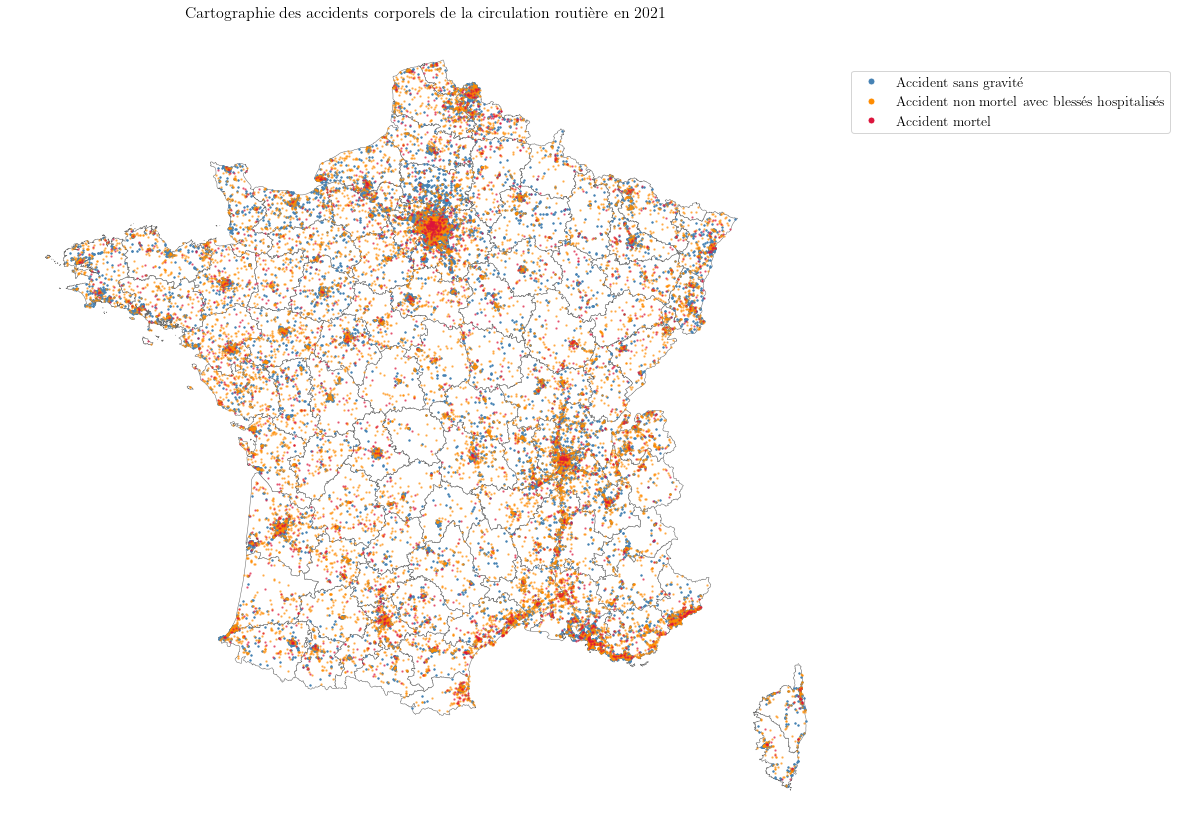

In [124]:
fig, ax = plt.subplots(figsize=(15,15))
carte_fra.plot(color='white', edgecolor='dimgray', linewidth=0.5, ax=ax)   #fond de carte
acc_2021_leger.plot(markersize=2, alpha=1, color='steelblue', ax=ax)    #accidents sans gravité
acc_2021_grave.plot(markersize=2, alpha=0.5, color='darkorange', ax=ax)    #accidents graves non mortels
acc_2021_mort.plot(markersize=2, alpha=0.5, color='crimson', ax=ax)    #accidents mortels
sns.despine()
plt.axis('off')

plt.title('Cartographie des accidents corporels de la circulation routière en 2021', fontsize=16)
#legende personnalisée
points_legende = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=7),
                  mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', markersize=7),
                  mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson', markersize=7)]
plt.legend(handles=points_legende, labels=['Accident sans gravité', 'Accident non mortel avec blessés hospitalisés', 'Accident mortel'], bbox_to_anchor=[1,0.95], fontsize=14)

im = plt.gcf()
im.savefig("img/carte_france.png", dpi=200, bbox_inches="tight")
plt.show()

## 5.2 Accidents dans les Côtes d'Armor sur la période 2019-2021

Imaginons être chargé par le Département des Côtes d'Armor d'indentifier les routes/lieux qui posent problème en terme d'accidents pour faire des aménagements. Regardons où ont eu lieu les accidents sur la période 2019-2021 (période sur laquelle on dispose des latitudes et longitudes des accidents).

In [161]:
# Sélection des accidents des Côtes d'Armor
acc_22 = df_caract.loc[(df_caract['dep']=='22') &          # accidents des cotes d'armor
                       (~df_caract['lat'].isna()) &        # avec latitude présente
                       (~df_caract['long'].isna())         # avec longitude présente
                      ]

#transformation des coordonnées des accidents en objet de type Point
acc_22['geometry'] = list(zip(acc_22['long'], acc_22['lat']))
acc_22['geometry']= acc_22['geometry'].apply(Point)

#transformation de acc_2021 en GeoDataframe avec la projection 
acc_22 = gpd.GeoDataFrame(acc_22, geometry='geometry')
acc_22= acc_22.set_crs('EPSG:4326')

# Passage date au format texte pour affichage des infobulles
acc_22['date'] = acc_22['date'].dt.date.astype('str')

# Pour chaque accident, calcul du nombre de morts et blessés
acc_22['nb_morts'] = 0
acc_22['nb_graves'] = 0
acc_22['nb_legers'] = 0

for i,row in tqdm(acc_22.iterrows()):
    usagers = df_usagers.loc[df_usagers['Num_Acc']==row['Num_Acc']]
    acc_22.loc[acc_22['Num_Acc']==row['Num_Acc'],'nb_morts'] = len(usagers.loc[usagers['grav']==2])
    acc_22.loc[acc_22['Num_Acc']==row['Num_Acc'],'nb_graves'] = len(usagers.loc[usagers['grav']==3])
    acc_22.loc[acc_22['Num_Acc']==row['Num_Acc'],'nb_legers'] = len(usagers.loc[usagers['grav']==4])

#distinction des accidents mortels et non mortels
acc_22_mort = acc_22.loc[acc_22['Num_Acc'].isin(num_mort)].reset_index(drop=True)
acc_22_grav = acc_22.loc[(~acc_22['Num_Acc'].isin(num_mort)) & (acc_22['Num_Acc'].isin(num_grave))].reset_index(drop=True)
acc_22_leger = acc_22.loc[(~acc_22['Num_Acc'].isin(num_mort)) & (~acc_22['Num_Acc'].isin(num_grave))].reset_index(drop=True)


acc_22_mort.head()

1131it [00:06, 178.40it/s]


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,adr,lat,long,date,nom_jour,nom_mois,geometry,nb_morts,nb_graves,nb_legers
0,201900001598,2,6,2019,02:54,3.0,22,22213,1,1.0,...,Le Bouillon,48.5081292,-1.9988723,2019-06-02,Dimanche,Juin,POINT (-1.99887 48.50813),1,0,0
1,201900003476,27,3,2019,14:00,1.0,22,22282,2,1.0,...,43 Boulevard de Penthievre,48.6273770,-2.2661110,2019-03-27,Mercredi,Mars,POINT (-2.26611 48.62738),1,0,0
2,201900005448,23,11,2019,03:30,3.0,22,22360,1,1.0,...,RN12,48.4877470,-2.7194070,2019-11-23,Samedi,Novembre,POINT (-2.71941 48.48775),1,0,0
3,201900007644,14,9,2019,14:25,1.0,22,22306,1,3.0,...,D78,48.3760900,-1.9513430,2019-09-14,Samedi,Septembre,POINT (-1.95134 48.37609),1,1,0
4,201900008271,20,10,2019,11:50,1.0,22,22166,2,2.0,...,Rue de Lannion,48.8067452,-3.3058119,2019-10-20,Dimanche,Octobre,POINT (-3.30581 48.80675),1,0,0


In [126]:
print("Nombre total d'accidents dans les Côtes d'Armor entre 2005 et 2021 :", len(acc_22))

Nombre total d'accidents dans les Côtes d'Armor entre 2005 et 2021 : 1131


In [174]:
# Création de la carte
carte22 = folium.Map(location=[48.43, -2.83], zoom_start=9, tiles=None)

# Ajout de fonds de cartes différents
folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(carte22)
folium.TileLayer('Stamen Terrain', name='Stamen Terrain').add_to(carte22)
folium.TileLayer('Stamen Toner', name='Stamen Toner').add_to(carte22)
folium.TileLayer('CartoDB Positron', name='Stamen Positron').add_to(carte22)


# Ajout des accidents non grave
groupe_leger = folium.FeatureGroup(name='<span style="color: steelblue;">Accident sans gravité</span>')
for i, row in acc_22_leger.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,  
        color=None,  
        fill=True,
        fill_color='steelblue',  
        fill_opacity=1,
        tooltip=f"<strong>Type :</strong> sans gravité <br>\
                <strong>Date :</strong> {acc_22_leger.iloc[i]['date']} <br>\
                <strong>Morts :</strong> {acc_22_leger.iloc[i]['nb_morts']} <br>\
                <strong>Blessés graves :</strong> {acc_22_leger.iloc[i]['nb_graves']} <br>\
                <strong>Blessés légers :</strong> {acc_22_leger.iloc[i]['nb_legers']} <br>"
    ).add_to(groupe_leger)

# Ajout des accidents graves non mortels
groupe_grave = folium.FeatureGroup(name='<span style="color: darkorange;">Accident non mortel avec blessés hospitalisés</span>')
for i, row in acc_22_grav.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,  
        color=None,  
        fill=True,
        fill_color='darkorange',  
        fill_opacity=1,
        tooltip=f"<strong>Type :</strong> non mortel avec blessés hospitalisés <br>\
                <strong>Date :</strong> {acc_22_grav.iloc[i]['date']} <br>\
                <strong>Morts :</strong> {acc_22_grav.iloc[i]['nb_morts']} <br>\
                <strong>Blessés graves :</strong> {acc_22_grav.iloc[i]['nb_graves']} <br>\
                <strong>Blessés légers :</strong> {acc_22_grav.iloc[i]['nb_legers']} <br>"
    ).add_to(groupe_grave)    

# Ajout des accidents mortels
groupe_mortel = folium.FeatureGroup(name='<span style="color: crimson;">Accident mortel</span>')
for i, row in acc_22_mort.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,  
        color=None,  
        fill=True,
        fill_color='crimson',  
        fill_opacity=1,
        tooltip=f"<strong>Type :</strong> mortel <br>\
                <strong>Date :</strong> {acc_22_mort.iloc[i]['date']} <br>\
                <strong>Morts :</strong> {acc_22_mort.iloc[i]['nb_morts']} <br>\
                <strong>Blessés graves :</strong> {acc_22_mort.iloc[i]['nb_graves']} <br>\
                <strong>Blessés légers :</strong> {acc_22_mort.iloc[i]['nb_legers']} <br>"
    ).add_to(groupe_mortel)

carte22.add_child(groupe_leger)
carte22.add_child(groupe_grave)
carte22.add_child(groupe_mortel)
folium.map.LayerControl('topleft', collapsed= False).add_to(carte22)    

carte22.save('img/carte22.html')
display(carte22)